## Angular Response function for LISA


In [450]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpmath import spherharm
from  nest import detectors as det
from nest import nell

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [451]:
L = 2.5e9 # [km]
c = 3e8 # [km/s]
f_star = c/2/np.pi/L # [Hz]

In [452]:
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

In [453]:
def e_plus(Theta_mesh,Phi_mesh):
    v = np.array([np.sin(Phi_mesh), -np.cos(Phi_mesh), np.zeros_like(Theta_mesh)])
    u = np.array([np.cos(Phi_mesh) * np.cos(Theta_mesh),np.sin(Phi_mesh) * np.cos(Theta_mesh),-np.sin(Theta_mesh)])
    return (np.einsum('i...,k...',u,u)-np.einsum('i...,k...',v,v))

def e_cross(Theta_mesh,Phi_mesh):
    v = np.array([np.sin(Phi_mesh), -np.cos(Phi_mesh), np.zeros_like(Theta_mesh)])
    u = np.array([np.cos(Phi_mesh) * np.cos(Theta_mesh),np.sin(Phi_mesh) * np.cos(Theta_mesh),-np.sin(Theta_mesh)])
    return (np.einsum('i...,k...',u,v)+np.einsum('i...,k...',v,u))

ortogonality condition.

In [454]:
Theta_vec = np.linspace(0,np.pi,100)
Phi_vec = np.linspace(0,2*np.pi,1)
Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
Omega = np.round(np.array([np.cos(Phi_mesh)*np.sin(Theta_mesh),np.sin(Phi_mesh)*np.sin(Theta_mesh),np.cos(Theta_mesh)]),20)
# Verify the orthogonality condition
print(np.einsum('lmij,lmij->lm',e_cross(Theta_mesh,Phi_mesh),e_cross(Theta_mesh,Phi_mesh)))
print(np.einsum('lmij,lmij->lm',e_plus(Theta_mesh,Phi_mesh),e_plus(Theta_mesh,Phi_mesh)))
print(np.einsum('lmij,lmij->lm',e_cross(Theta_mesh,Phi_mesh),e_plus(Theta_mesh,Phi_mesh)))

[[2.                 1.9999999999999998 2.0000000000000004
  2.                 2.                 1.9999999999999998
  2.                 1.9999999999999998 1.9999999999999998
  2.                 2.                 2.
  2.                 2.                 1.9999999999999998
  2.                 2.                 2.
  2.                 2.                 1.9999999999999998
  2.                 1.9999999999999998 2.0000000000000004
  2.0000000000000004 2.                 2.
  2.                 2.                 1.9999999999999998
  2.                 2.0000000000000004 1.9999999999999998
  1.9999999999999998 2.0000000000000004 2.
  1.9999999999999998 2.0000000000000004 2.
  1.9999999999999998 2.                 1.9999999999999998
  1.9999999999999998 2.                 2.
  1.9999999999999998 2.                 2.
  1.9999999999999998 2.                 2.
  1.9999999999999998 2.                 2.
  1.9999999999999998 2.                 2.
  1.9999999999999998 2.                

## LISA Response function



In [455]:
def Evaluate_Product(l_vec,Theta_mesh,Phi_mesh,tensor):
    if tensor == 'plus':
        e_values = e_plus(Theta_mesh,Phi_mesh)
    elif tensor == 'cross':
        e_values = e_cross(Theta_mesh,Phi_mesh)
    result = np.einsum('i,j,lmij', l_vec,l_vec, e_values) # [n_Phi, n_Theta]
    return result
    

Transfer function.
\begin{equation*}
\mathcal{T}(f,\hat{l}_{AB},\hat{n})=\frac{1}{2}\left[e^{ -\pi i f L (1+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1+\hat{k}\cdot \hat{l}_{AB})\right)+ e^{ -\pi i f L (3+\hat{k}\cdot \hat{l}_{AB})} {\rm{sinc}}\left(f L (1-\hat{k}\cdot \hat{l}_{AB})\right)\right]
\end{equation*}



In [456]:
# Build the transfer function
def F_cal(l,Omega,f_vec,f_star):
    inner = np.einsum('i,ijk',l,Omega)
    return 1/2 * (  np.sinc(f_vec/2/np.pi/f_star * (1-inner)) * np.exp(-1j*f_vec/2/f_star * (3+inner))\
                                    + np.sinc(f_vec/2/np.pi/f_star * (1+inner)) * np.exp(-1j*f_vec/2/f_star * (1+inner)))

In [9]:
print(3e8/(2*np.pi*2.5e9))

0.019098593171027443


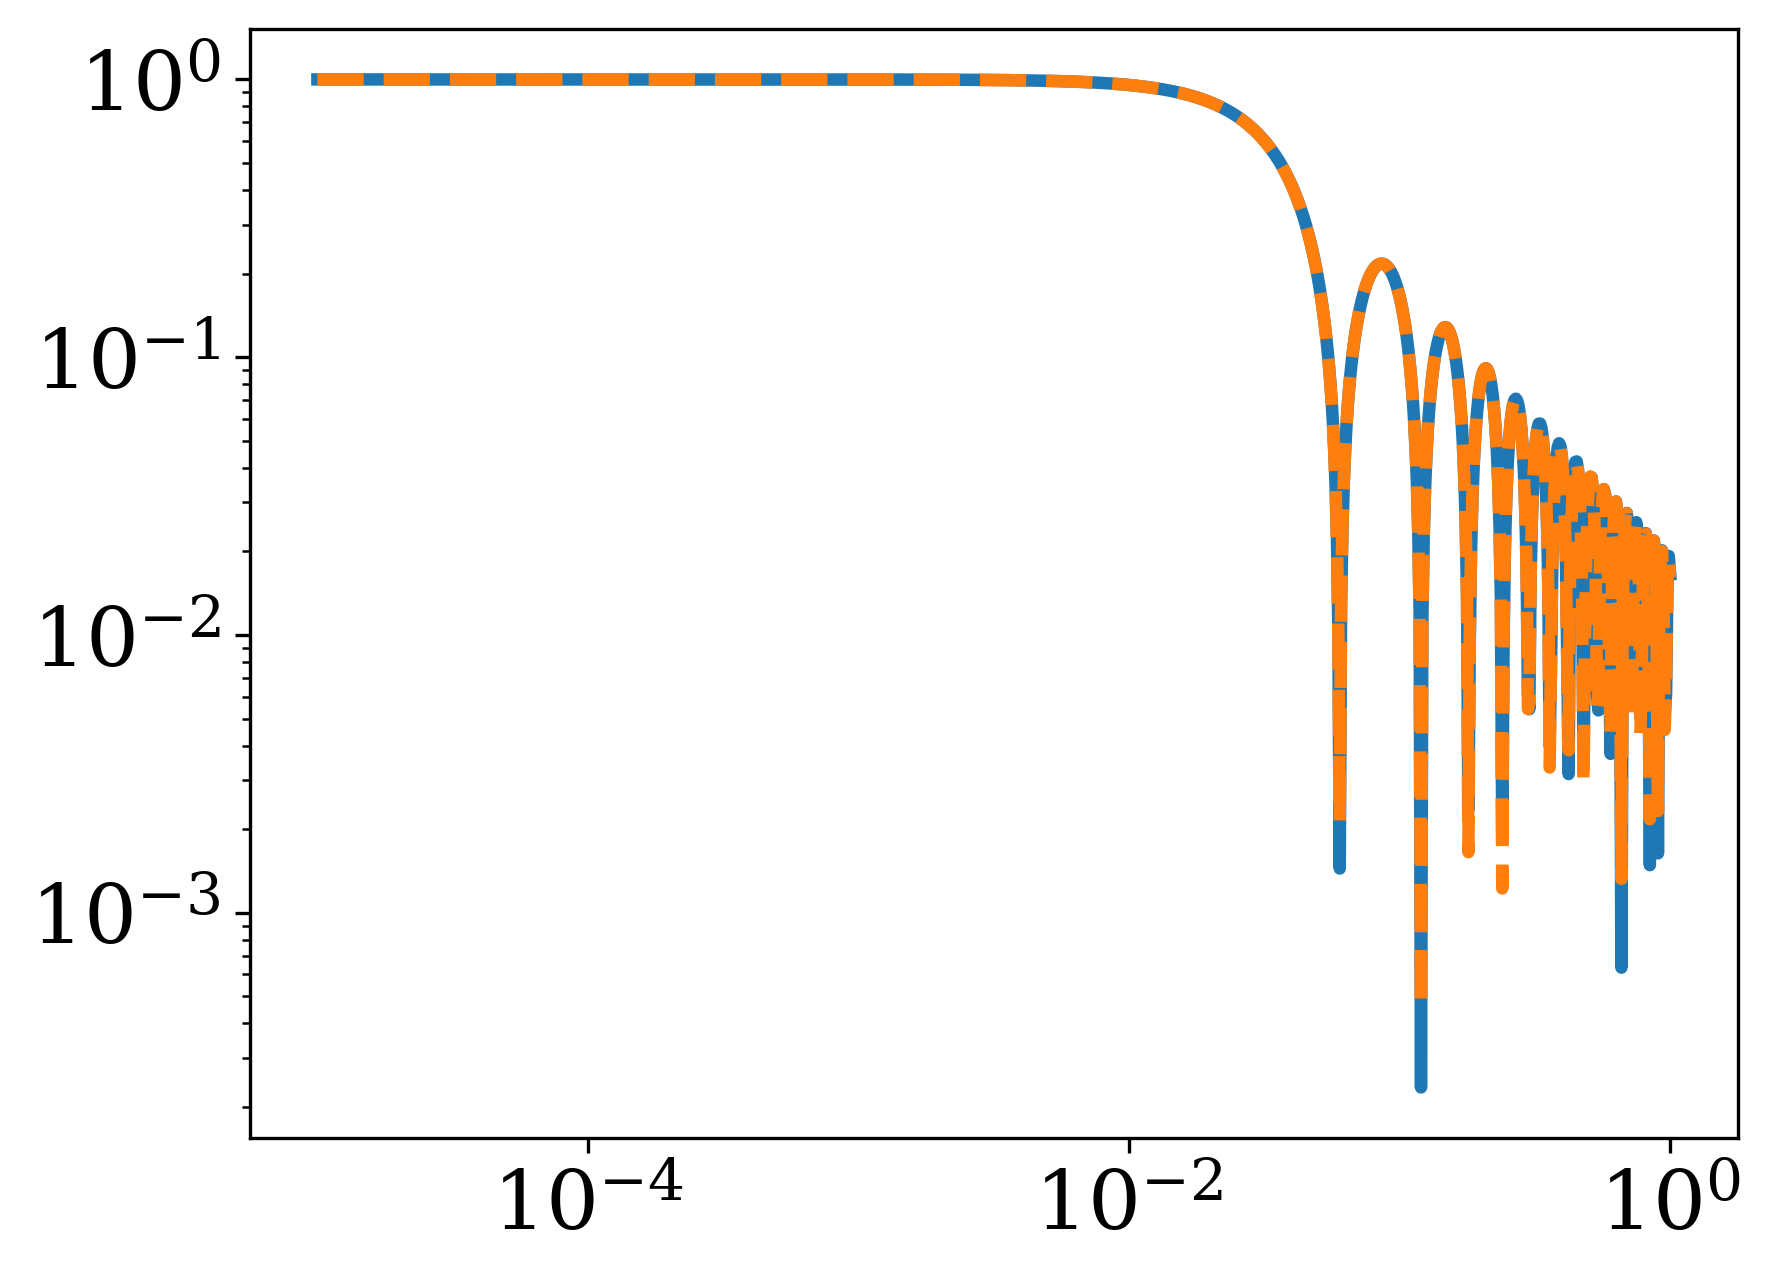

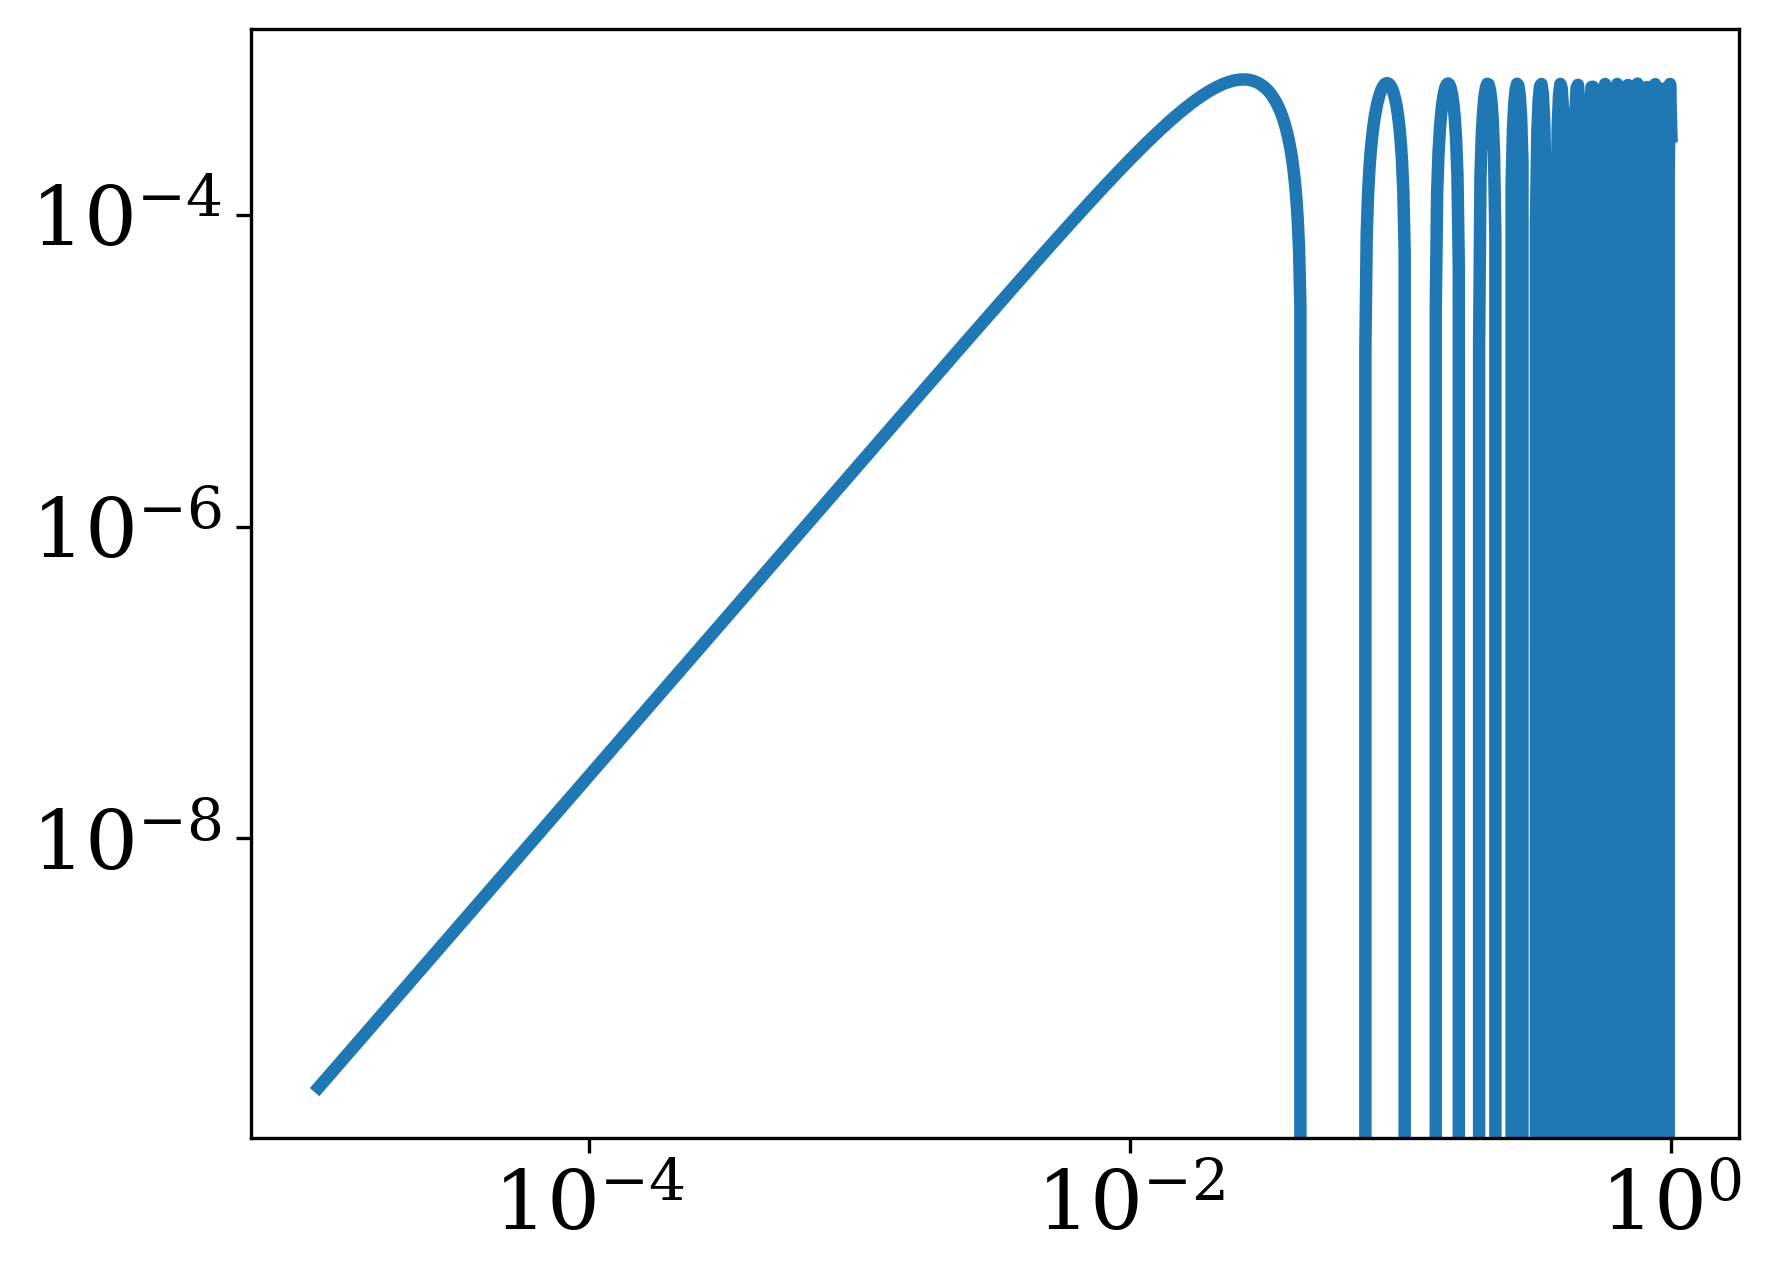

In [458]:
# check the transfer function

# Build the transfer function
def F(l,Omega,f_vec,f_star):
    inner = np.einsum('i,i',l,Omega)
    return 1/2 * (  np.sinc(f_vec/2/np.pi/f_star * (1-inner)) * np.exp(-1j*f_vec/2/f_star * (3+inner))\
                                    + np.sinc(f_vec/2/np.pi/f_star * (1+inner)) * np.exp(-1j*f_vec/2/f_star * (1+inner)))

Omega_local = np.round(np.array([np.cos(0)*np.sin(0),np.sin(0)*np.sin(0),np.cos(0)]),20)

f = np.logspace(-5,0,1000)
f_star = c/2/np.pi/L # [Hz]
lBA = xB - xA

F = F(lBA,Omega_local,f,f_star)

theta = np.array(0)
phi = np.array(0)
theta = np.expand_dims(theta, axis=(0,1))
phi = np.expand_dims(phi, axis=(0,1))
F_GWBird = nell.get_tf(f, 'LISA 1', theta, phi, 0, shift_angle=None)

F_GWBird = np.squeeze(F_GWBird)

# plot

plt.figure()
plt.plot(f, np.abs(F))
plt.plot(f, np.abs(F_GWBird), linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure()
plt.plot(f, F- F_GWBird)
plt.xscale('log')
plt.yscale('log')
plt.show()





Check $\mathcal{T} (f\ll f_*) = 1$. 

In [242]:
f_vec_try = np.logspace(-5,-3,200)
print(np.real(F_cal(lBA,Omega,np.expand_dims(f_vec_try,axis=(1,2)),f_star)))

[[[0.9999998172295581 0.9999998150434608 0.9999998128366008 ...
   0.9999998128366008 0.9999998150434608 0.9999998172295581]]

 [[0.9999998085715588 0.9999998062819039 0.9999998039705029 ...
   0.9999998039705029 0.9999998062819039 0.9999998085715588]]

 [[0.999999799503422  0.9999997971053043 0.9999997946844104 ...
   0.9999997946844104 0.9999997971053043 0.999999799503422 ]]

 ...

 [[0.9983347175598329 0.9983148018664487 0.9982946971851567 ...
   0.9982946971851567 0.9983148018664487 0.9983347175598329]]

 [[0.9982558729335407 0.9982350144372651 0.9982139580145075 ...
   0.9982139580145075 0.9982350144372651 0.9982558729335407]]

 [[0.9981732973707995 0.9981514514704629 0.9981293982829936 ...
   0.9981293982829936 0.9981514514704629 0.9981732973707995]]]


### Step 3


\begin{equation*}
    \mathcal{R}_{AA'}(f) = \int \frac{d\Omega_{\vec {k}}}{4 \pi} \left[ \mathcal{R}_A^+(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^+}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n}) + \mathcal{R}_A^{\times}(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}){\mathcal{R}_{A'}^{\times}}^*(f,\hat{l}_{A'B'},\hat{l}_{A'C'},\hat{n})\right]\,,
\end{equation*}
with
\begin{equation*}
\mathcal{R}_A^P(f,\hat{l}_{AB},\hat{l}_{AC},\hat{n}) = \frac{1}{2} e^{-i2\pi f \hat{n}\cdot\vec{x}_A/c} \left[\mathcal{T}(f,\hat{l}_{AB},\hat{n})-\mathcal{T}(f,\hat{l}_{AC},\hat{n})  \right]
\end{equation*}



warning: it is not commutative to put the exponential here or at the whole term of the angular pattern function as in eq.4.15 Bartolo et al. 2022

In [392]:
def F_det(l1,l2,Theta_mesh,Phi_mesh,f_vec,f_star,x_det):
    Omega = np.round(np.array([np.cos(Phi_mesh)*np.sin(Theta_mesh),np.sin(Phi_mesh)*np.sin(Theta_mesh),np.cos(Theta_mesh)]),20)
    f_exp = np.expand_dims(f_vec, axis=(1,2))
    F_1 = F_cal(l1,Omega,f_exp,f_star)
    F_2 = F_cal(l2,Omega,f_exp,f_star)
    return  0.5*(+ F_1 * Evaluate_Product(l1,Theta_mesh,Phi_mesh,'plus')\
               - F_2 * Evaluate_Product(l2,Theta_mesh,Phi_mesh,'plus')),\
             0.5*( F_1 * Evaluate_Product(l1,Theta_mesh,Phi_mesh,'cross')\
               - F_2 * Evaluate_Product(l2,Theta_mesh,Phi_mesh,'cross')),

def Response(l_det1,l_det2,x_det1,x_det2,f_vec,f_star):
    Theta_vec = np.linspace(0,np.pi,100)
    Phi_vec = np.linspace(0,2*np.pi,100)
    f_exp = np.expand_dims(f_vec, axis=(1,2))
    Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
    F1_p, F1_c = F_det(l_det1[0],l_det1[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det1)
    F2_p, F2_c = F_det(l_det2[0],l_det2[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det2)
    R_integrand = (F1_p  * np.conj(F2_p) \
                + F1_c * np.conj(F2_c))* np.exp(-1j* f_exp/f_star * np.einsum('i,ijk',x_det1- x_det2,Omega))
    R1 = np.trapz(R_integrand,Phi_vec,axis=1)
    R = np.real(np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1))*1/4/np.pi
    return R

#tinto
#Saito

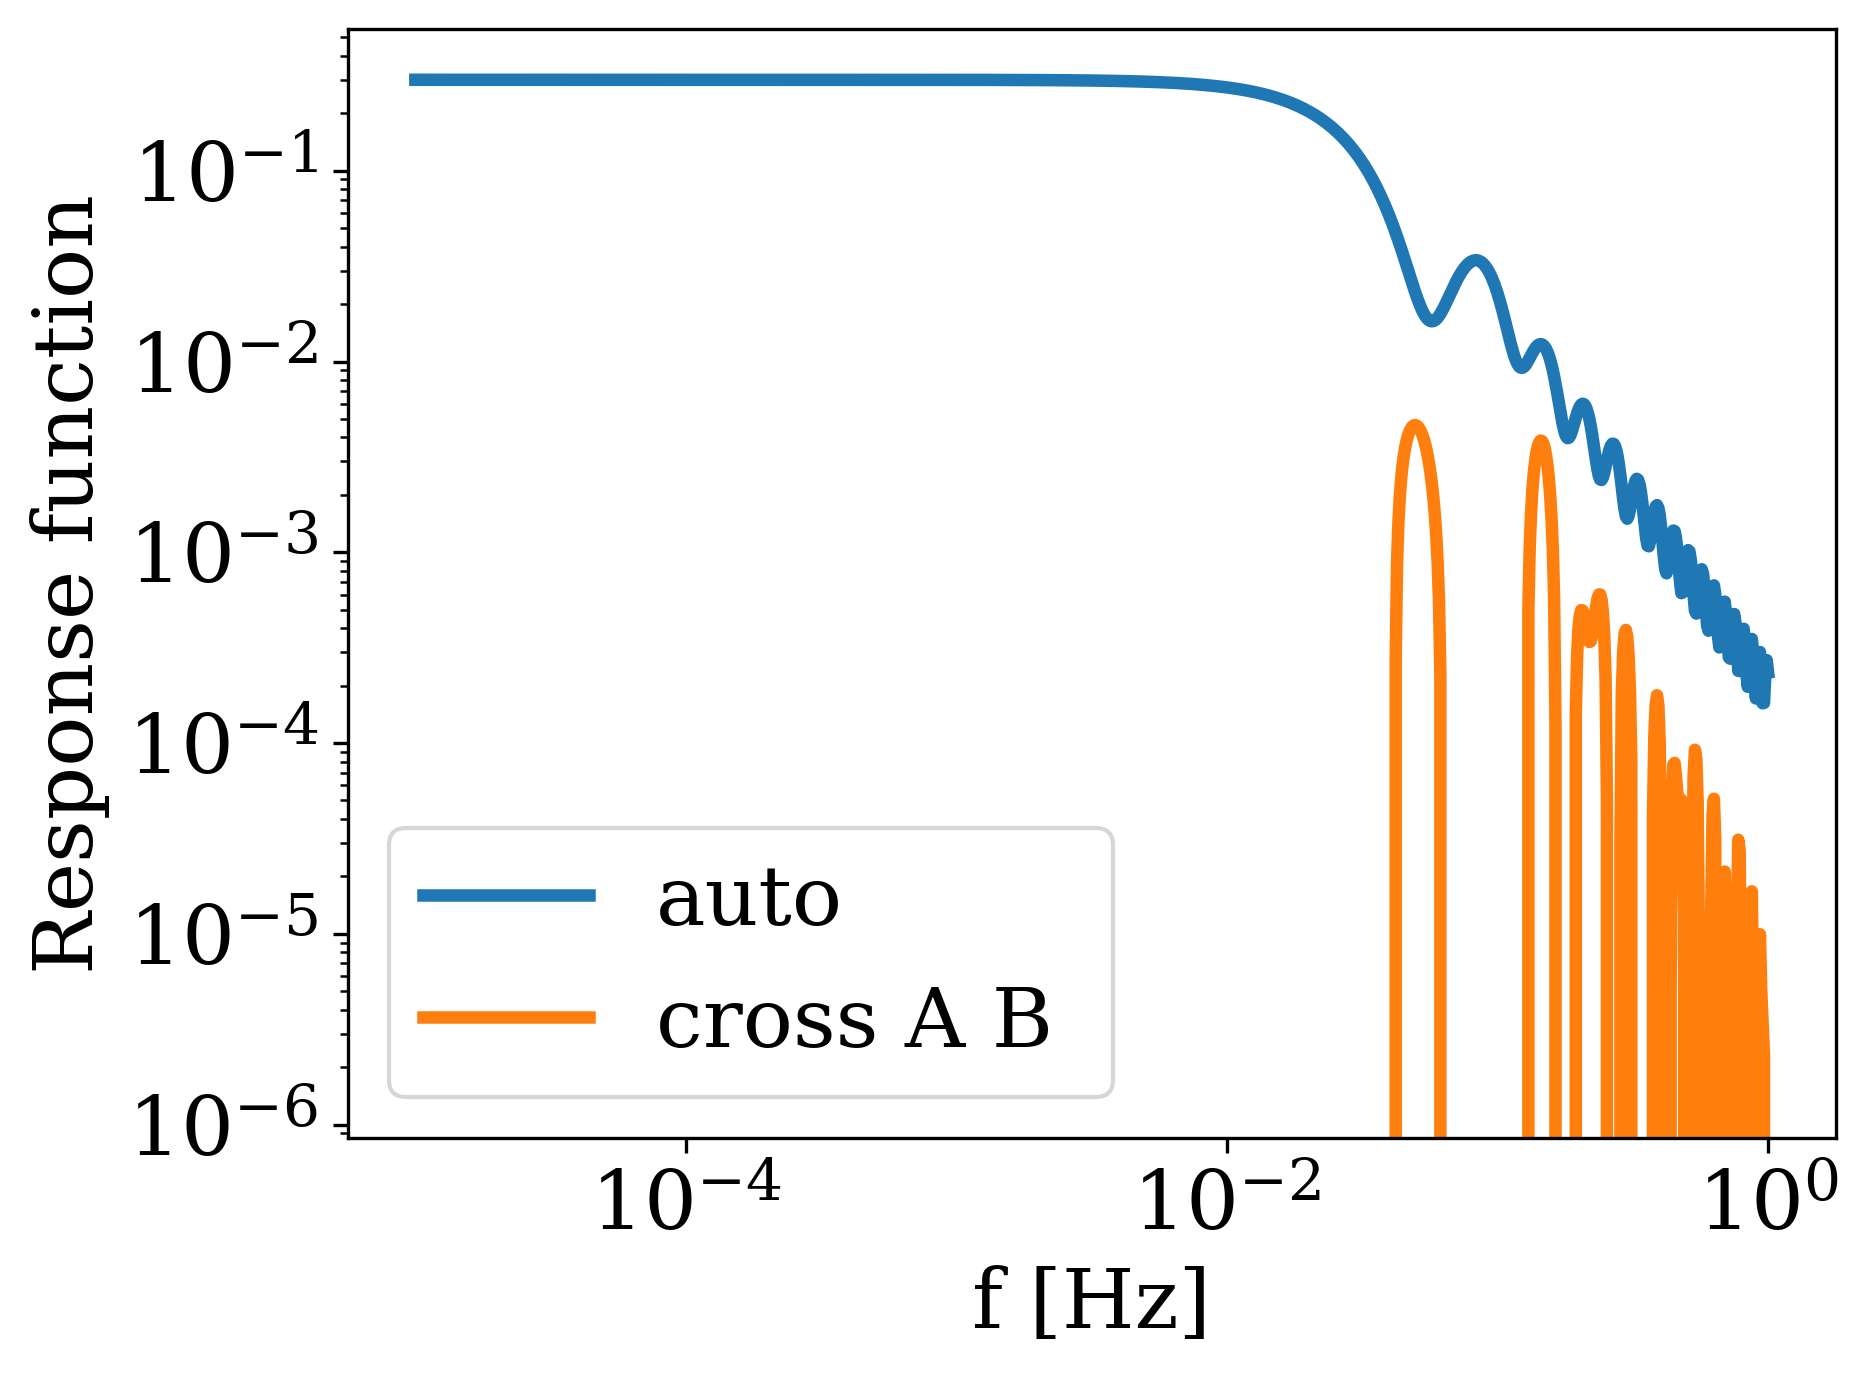

In [393]:
L = 2.5e9 # [m]
c = 3e8 # [m/s]
f_star = c/2/np.pi/L # [Hz]
xA = np.array([0,0,0])
xB = np.array([+1/2, np.sqrt(3)/2, 0])
xC = np.array([-1/2, np.sqrt(3)/2, 0])
lBA = xB - xA
lCA = xC - xA
lBC = xB - xC

lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)
f_vec = np.logspace(-5, 0, 1000)
R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)

plt.loglog(f_vec, R1_vec, label='auto')
plt.loglog(f_vec, R2_vec, label='cross A B ')
plt.xlabel('f [Hz]')
plt.ylabel('Response function')
plt.legend()


In [394]:
def Ylm(l,m,theta,phi):
    return spherharm(l,m,theta,phi)


In [395]:
Ylm(-2,2,0.1,0.1)

mpc(real='0.0', imag='0.0')

In [423]:
from scipy.special import sph_harm

def Ylm(l,m,theta,phi):
    return sph_harm(m,l,phi,theta)

def Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m):
    Theta_vec = np.linspace(0,np.pi,100)
    Phi_vec = np.linspace(0,2*np.pi,100)
    f_exp = np.expand_dims(f_vec, axis=(1,2))
    Theta_mesh, Phi_mesh = np.meshgrid(Theta_vec, Phi_vec)
    F1_p, F1_c = F_det(l_det1[0],l_det1[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det1)
    F2_p, F2_c = F_det(l_det2[0],l_det2[1],Theta_mesh,Phi_mesh,f_vec,f_star,x_det2)
    R_integrand_ell = (F1_p  * np.conj(F2_p) \
                + F1_c * np.conj(F2_c)) * Ylm(ell,m,Theta_mesh,Phi_mesh)*np.sqrt(4*np.pi)\
                      * np.exp(-1j* f_exp/f_star * np.einsum('i,ijk',x_det1- x_det2,Omega))  #SPHERICAL HARMONIC redefined according to Eq. 4.2 paper LISA anisotropies
    R1 = np.trapz(R_integrand_ell,Phi_vec,axis=1)
    #Rellm = np.real(np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1))/4/np.pi
    Rellm = np.trapz(R1 * np.sin(Theta_vec),Theta_vec,axis=1)/4/np.pi
    return Rellm

In [424]:
# Verify the normalization
lA = (lBA,lCA)
lB = (-lBC,-lBA)
lC = (-lCA,lBC)

f_vec = np.unique(np.concatenate((np.logspace(-5, -2, 10),np.linspace(1e-2,1e-1,60),np.linspace(1e-1, 1, 400))))

R1_vec = Response(lA,lA,xA,xA,f_vec,f_star)
R2_vec = Response(lA,lB,xA,xB,f_vec,f_star)

In [425]:
f_vec = np.unique(np.concatenate((np.logspace(-5, -2, 10),np.linspace(1e-2,1e-1,60),np.linspace(1e-1, 1, 400))))

R1_vec_ell = Response_ell(lA,lA,xA,xA,f_vec,f_star, 0, 0)
R2_vec_ell = Response_ell(lA,lB,xA,xB,f_vec,f_star, 0, 0)

/opt/anaconda3/envs/dethenv/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/dethenv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


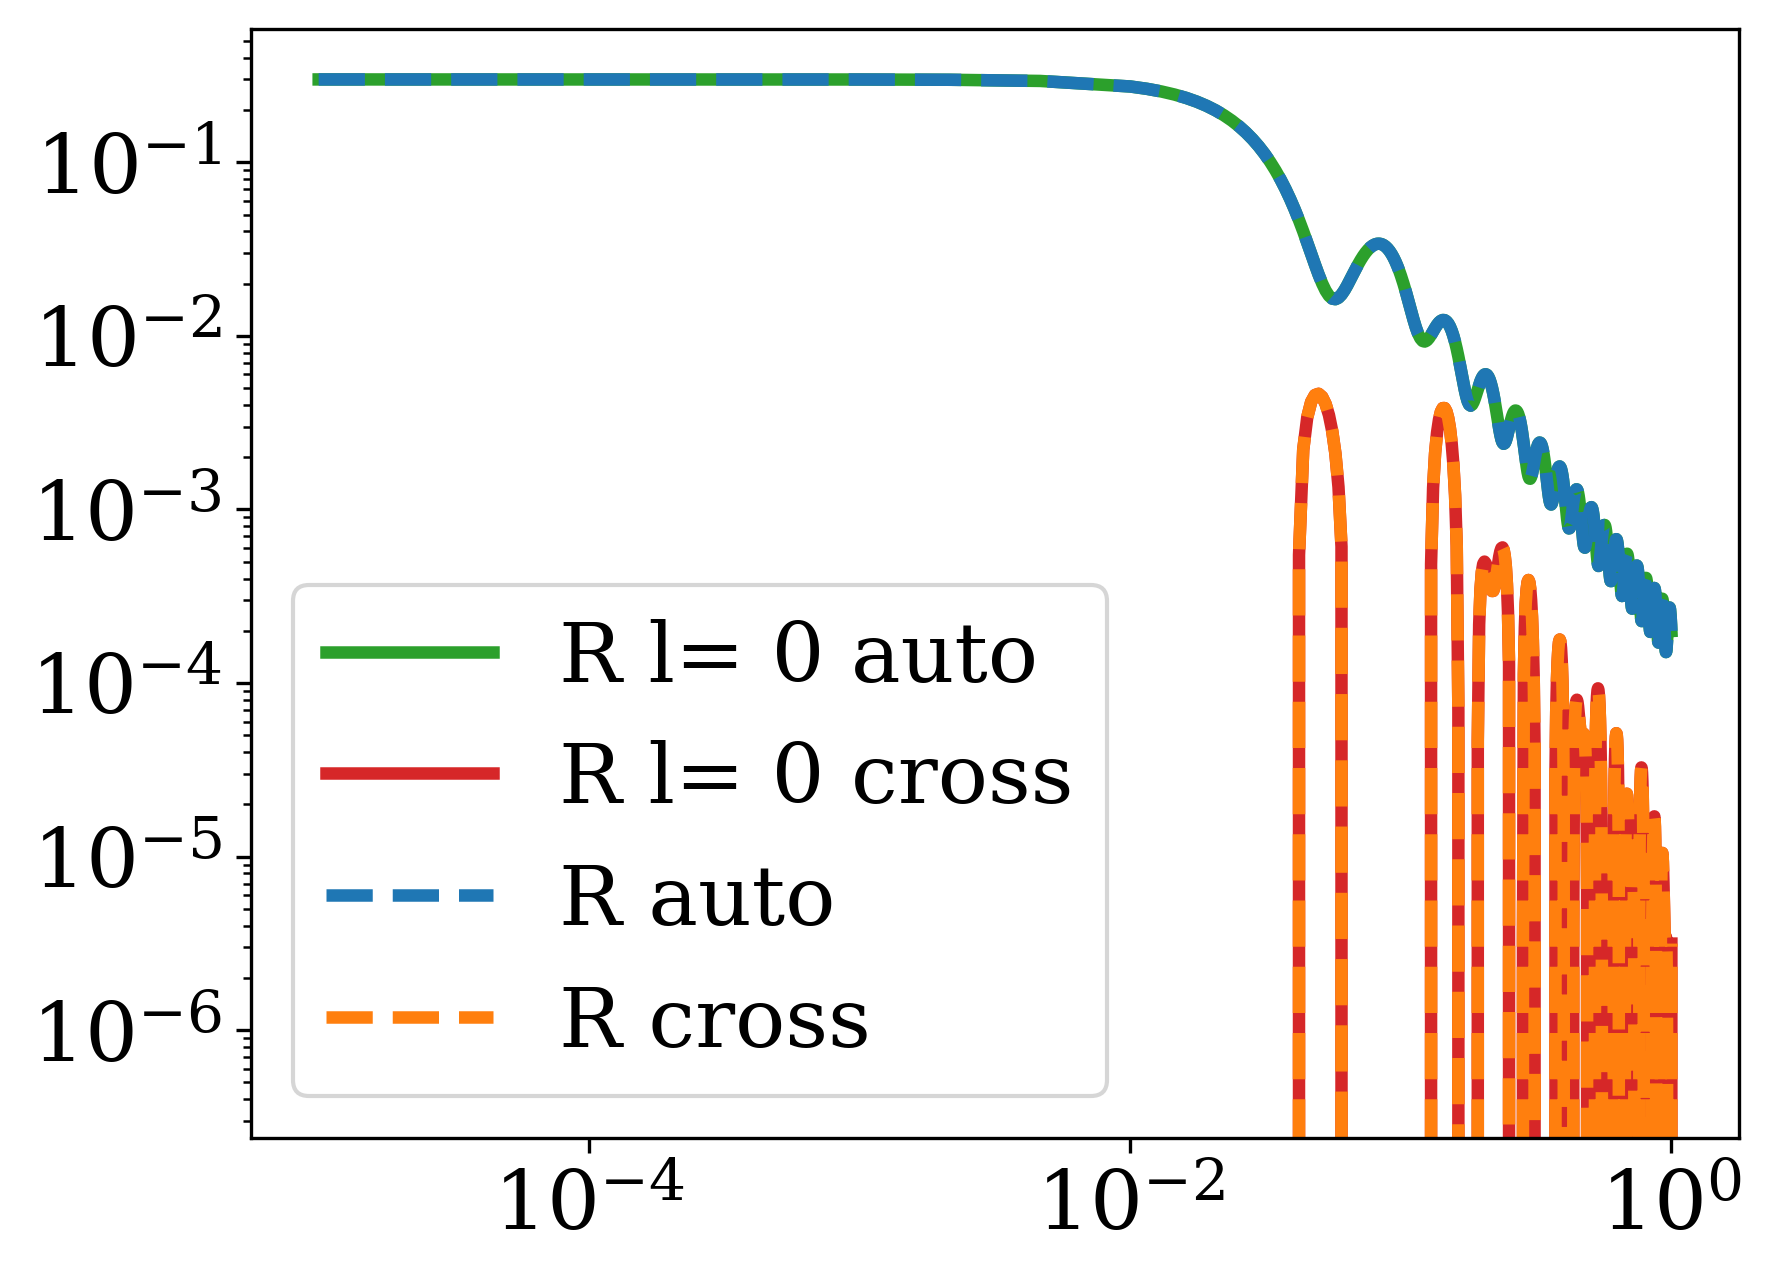

In [426]:
plt.loglog(f_vec,(R1_vec_ell),label='R l= 0 auto',c='C2')
plt.loglog(f_vec,(R2_vec_ell),label='R l= 0 cross',c='C3')
plt.loglog(f_vec,R1_vec,label='R auto',linestyle='--')
plt.loglog(f_vec,R2_vec,label='R cross',linestyle='--')
plt.legend()

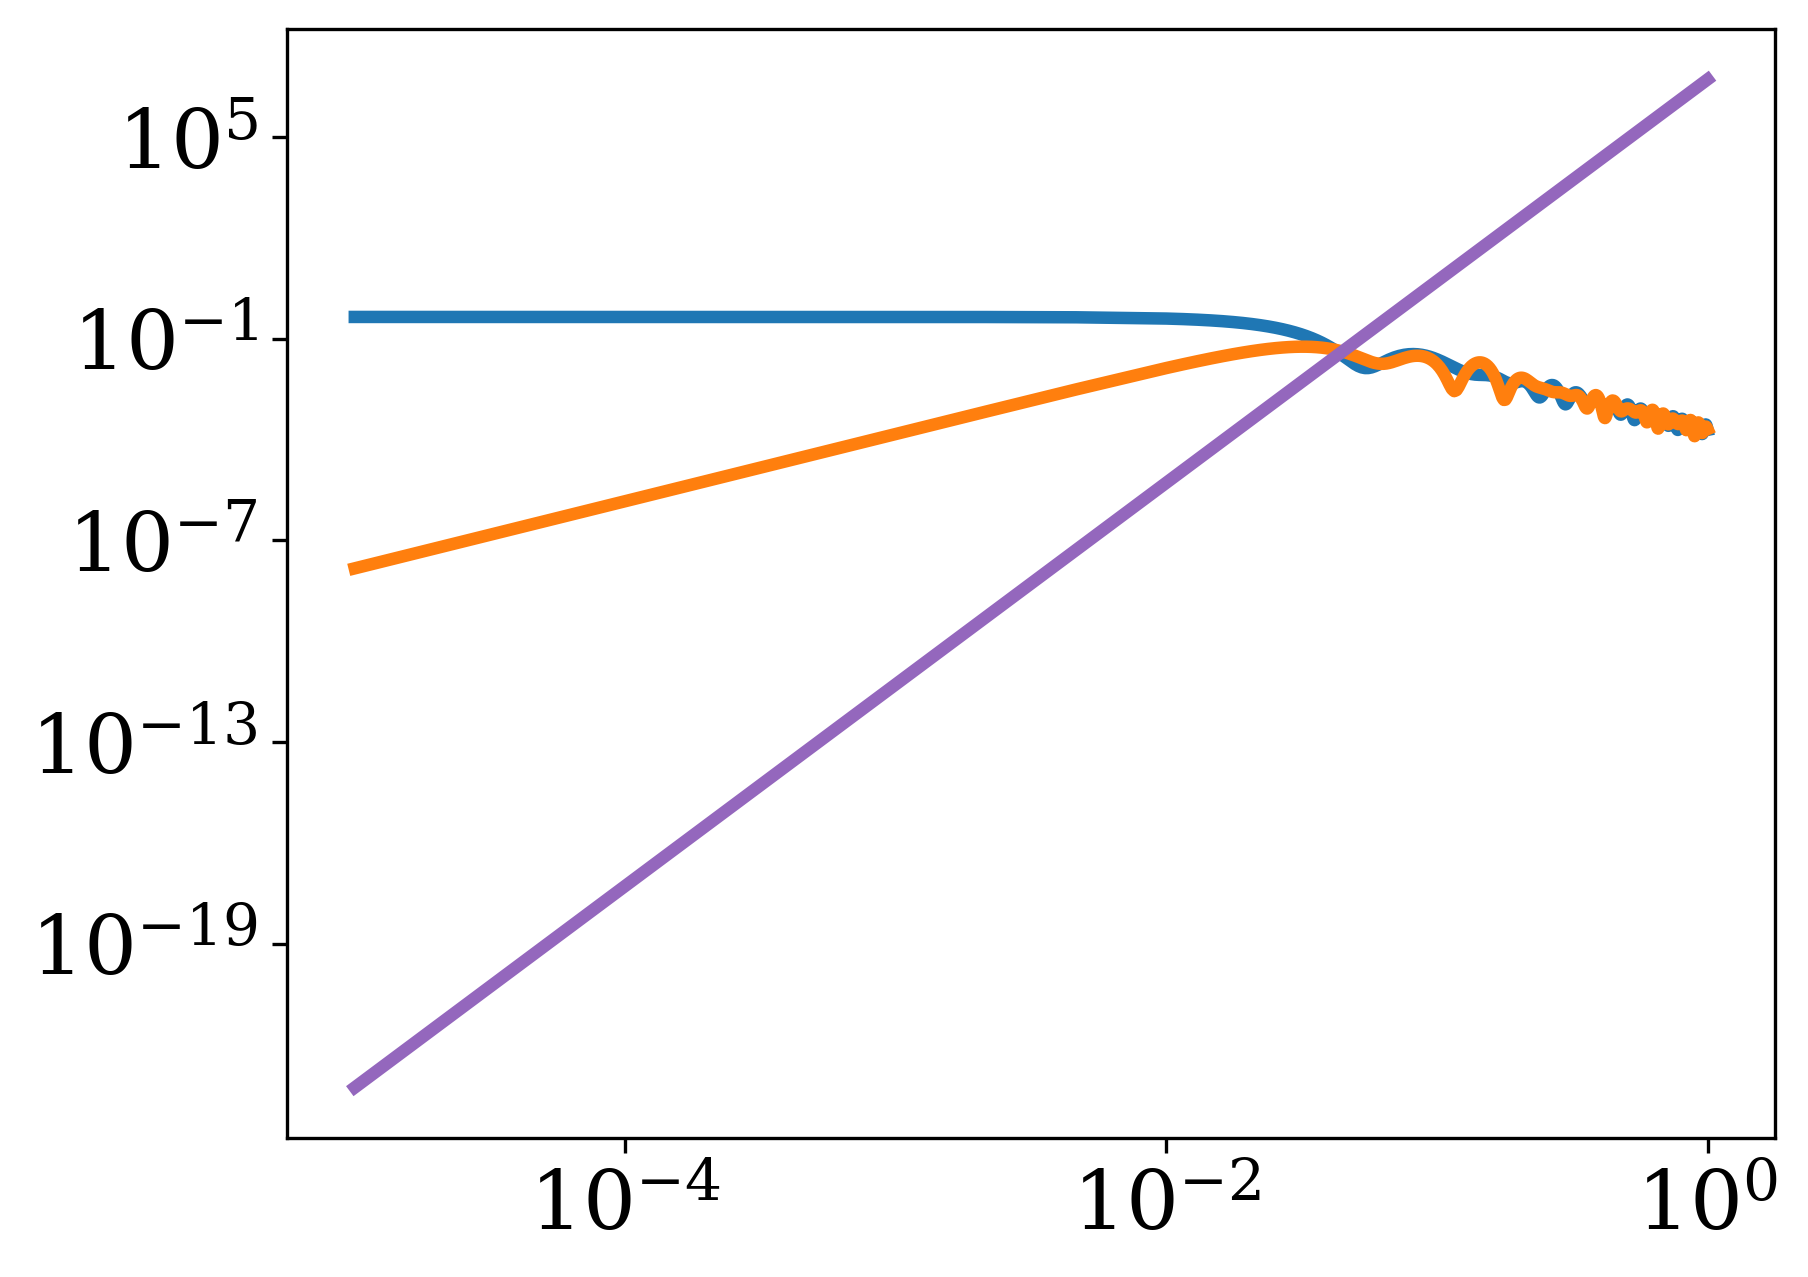

In [427]:
RAAell = R1_vec_ell - R2_vec_ell

RTT0 = R1_vec_ell + 2* R2_vec_ell

f = np.logspace(-5, 0, 100)
f_star = 0.019 # Hz
x = f/f_star
LISA_Rell_0_TT_interpolated = x**6/4032

plt.loglog(f_vec,(RAAell),label='RAA',c='C0')
plt.loglog(f_vec,(RTT0),label='RTT0',c='C1')
plt.loglog(f,LISA_Rell_0_TT_interpolated,label='LISA Rell 0 TT',c='C4')



In [428]:
def sum_m(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell):
    m = np.linspace(-ell,ell,2*ell+1)
    Rell = np.zeros_like(f_vec,dtype=complex)
    #Rell = np.zeros_like(f_vec)
    for i in range(len(m)):
        R = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i])
        #R2 = np.abs(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i]))**2
        Rstar = np.conj(R)
        Rell += R*Rstar
        #Rell += R2
    return np.sqrt(Rell)

In [429]:
def sum_m_AET(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell):
    mvec = np.linspace(-ell,ell,2*ell+1)
    RlAA = np.zeros_like(f_vec,dtype=complex)
    RlTT = np.zeros_like(f_vec,dtype=complex)
    RlAE = np.zeros_like(f_vec,dtype=complex)
    RlAT = np.zeros_like(f_vec,dtype=complex)
    if int(ell)% 2 == 0:
        for m in mvec:
            R1 = Response_ell(l_det1,l_det1,x_det1,x_det1,f_vec,f_star,ell,m)
            R2 = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m)
            #RAA = 1/4*np.abs(1+np.exp(-4/3*1j*m[i]*np.pi)*(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i])))
            #RAE = 1/3*(1+2*np.cos(2*m[i]*np.pi/3))**2*np.abs(Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m[i]))**2
            RlAA += np.abs((1+np.exp(-4j/3*m*np.pi)) * R1 - 2 * R2)**2
            RlTT += np.abs(R1 + 2*R2)**2*(1+2*np.cos(2*m*np.pi/3))**2 
            RlAE += (np.sin(m*np.pi/3))**2 * np.abs((1+np.exp(2j/3*m*np.pi))*R1 - 2 * R2)**2
            RlAT += (np.sin(m*np.pi/3))**2 * np.abs((1+np.exp(2j/3*m*np.pi))*R1 + R2)**2
            #Rell_rot += RAE
    else:  
        for m in mvec:
            R2 = Response_ell(l_det1,l_det2,x_det1,x_det2,f_vec,f_star,ell,m)
            RlAE += (1+2*np.cos(2*m*np.pi/3))**2 * np.abs(R2)**2
            RlAT += (np.sin(m*np.pi/3)**2 * np.abs(R2)**2)*3
    return np.sqrt(np.real(RlAA)/4), np.sqrt(np.real(RlTT)/9), np.sqrt(np.real(RlAE)/3), np.sqrt(2*np.real(RlAT)/3)

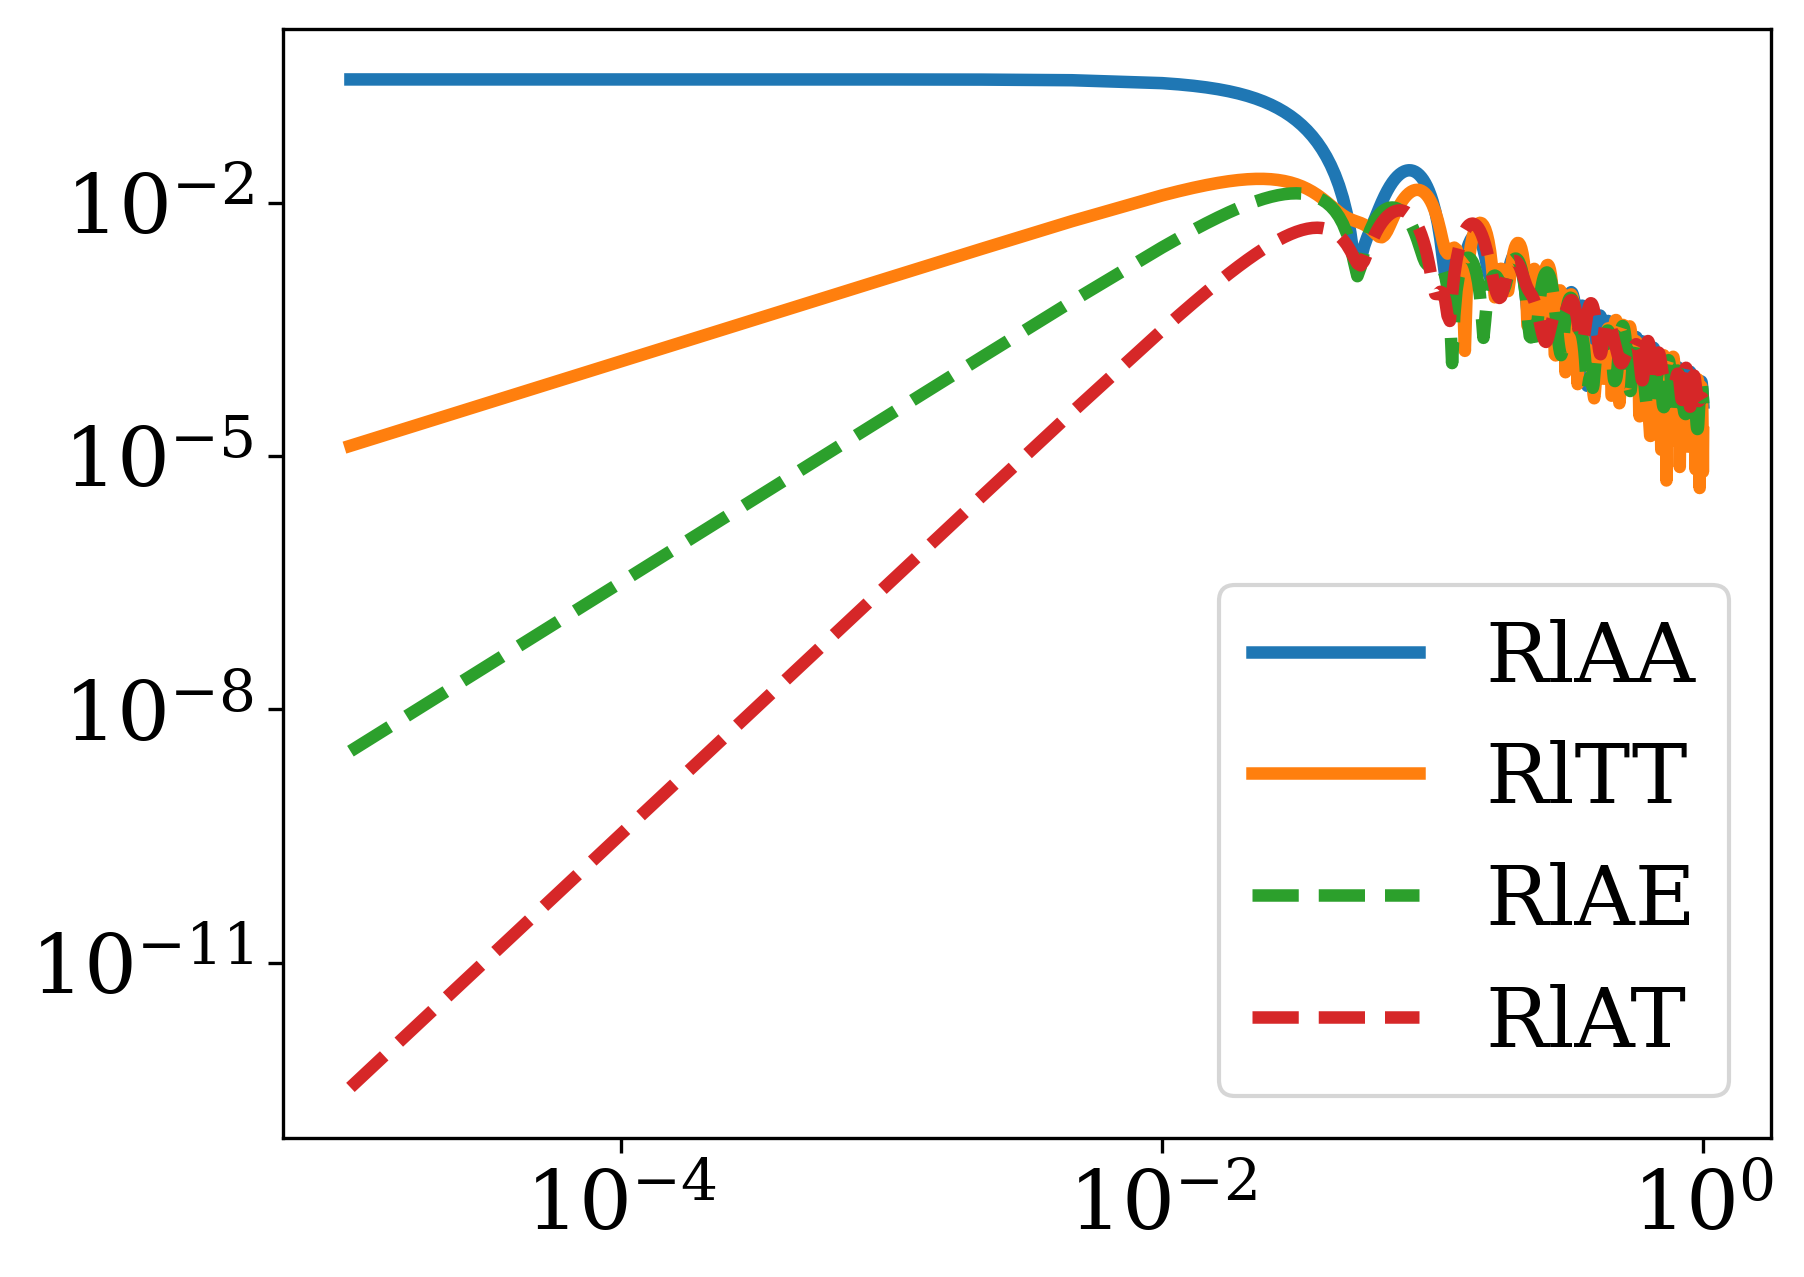

In [430]:
R = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,2)

plt.loglog(f_vec, R[0],label='RlAA',c='C0')
plt.loglog(f_vec,R[1],label='RlTT',c='C1')
plt.loglog(f_vec,R[2],label='RlAE',c='C2', linestyle='--')
plt.loglog(f_vec,R[3],label='RlAT',c='C3', linestyle='--')
plt.legend()


# plt.loglog(f_vec, R[2],label='RAA',c='C0')
# plt.ylim(1e-5,1e0)

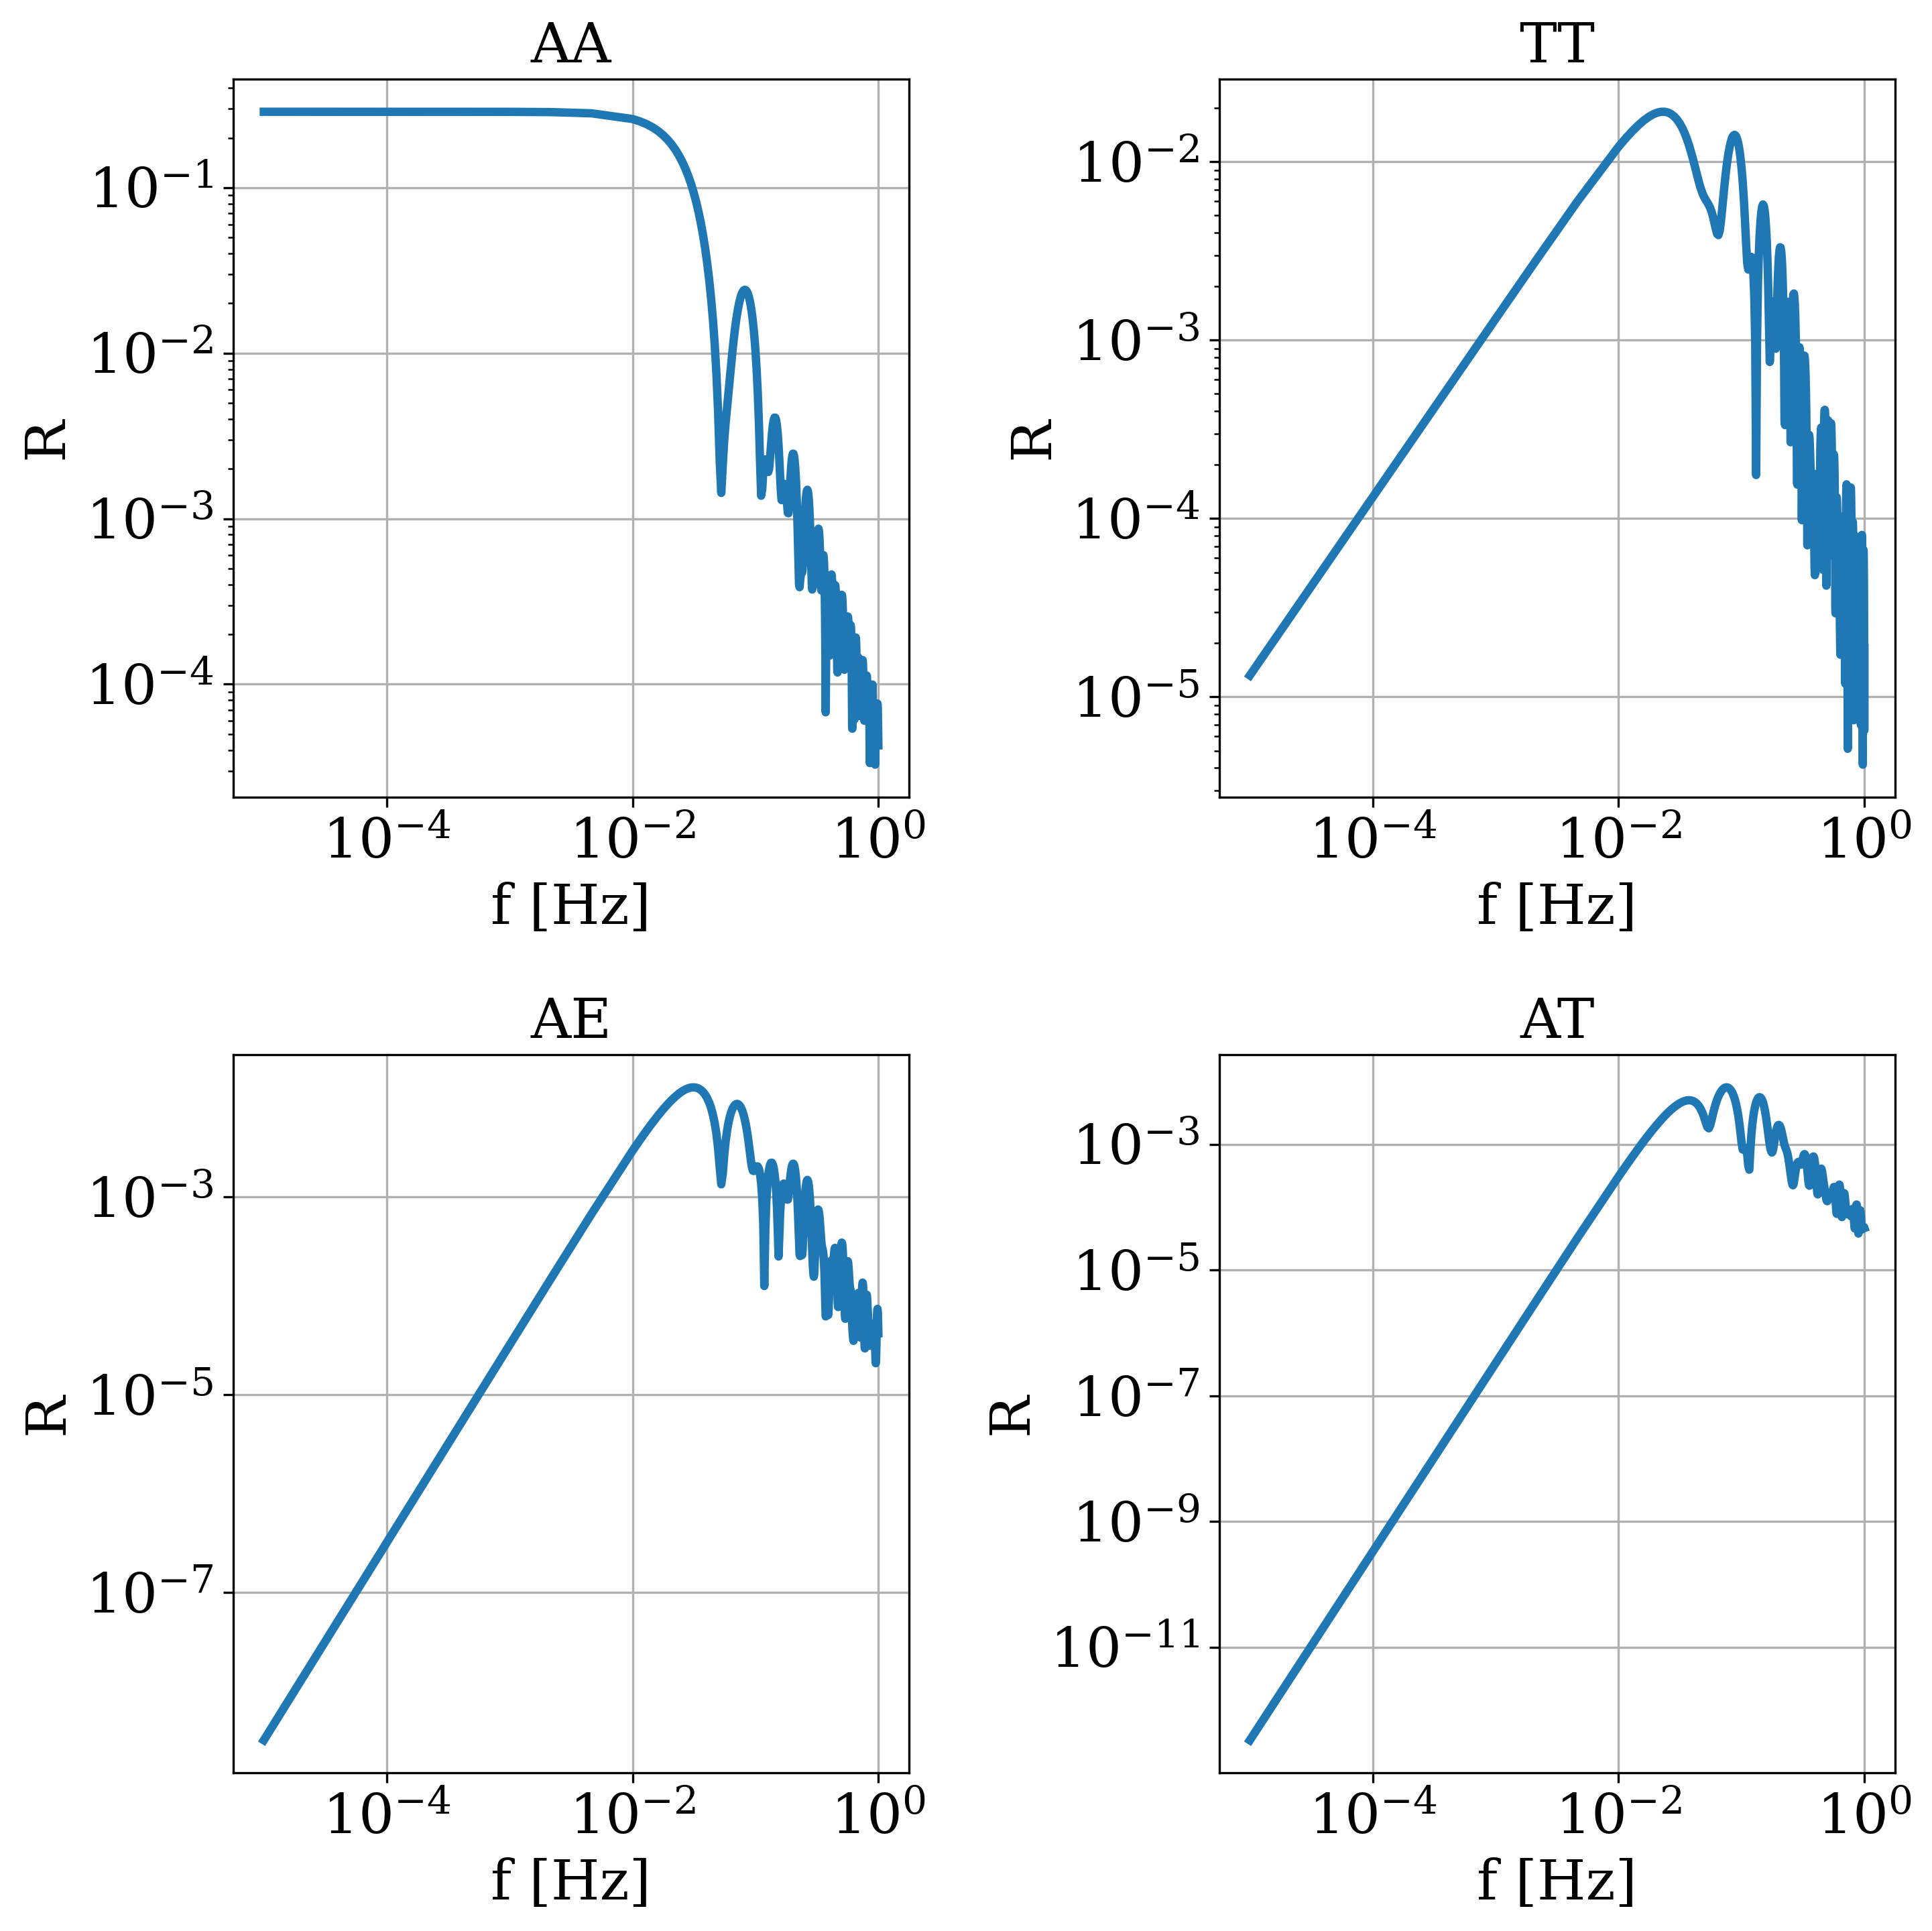

In [431]:
#f_vec = np.array([1e-3,1e-2])
l_value = 2
R = sum_m_AET(lA,lB,xA,xB,f_vec,f_star,l_value)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax = axs.flatten()
for i, axis in enumerate(ax):
    # axis.set_xlim(1e-3, 1)
    # axis.set_ylim(1e-7, 1)
    axis.set_title(['AA','TT','AE','AT'][i])
    axis.loglog(f_vec, R[i])
    axis.set_xlabel('f [Hz]')
    axis.set_ylabel('R')
    axis.grid()
plt.tight_layout()
plt.show()

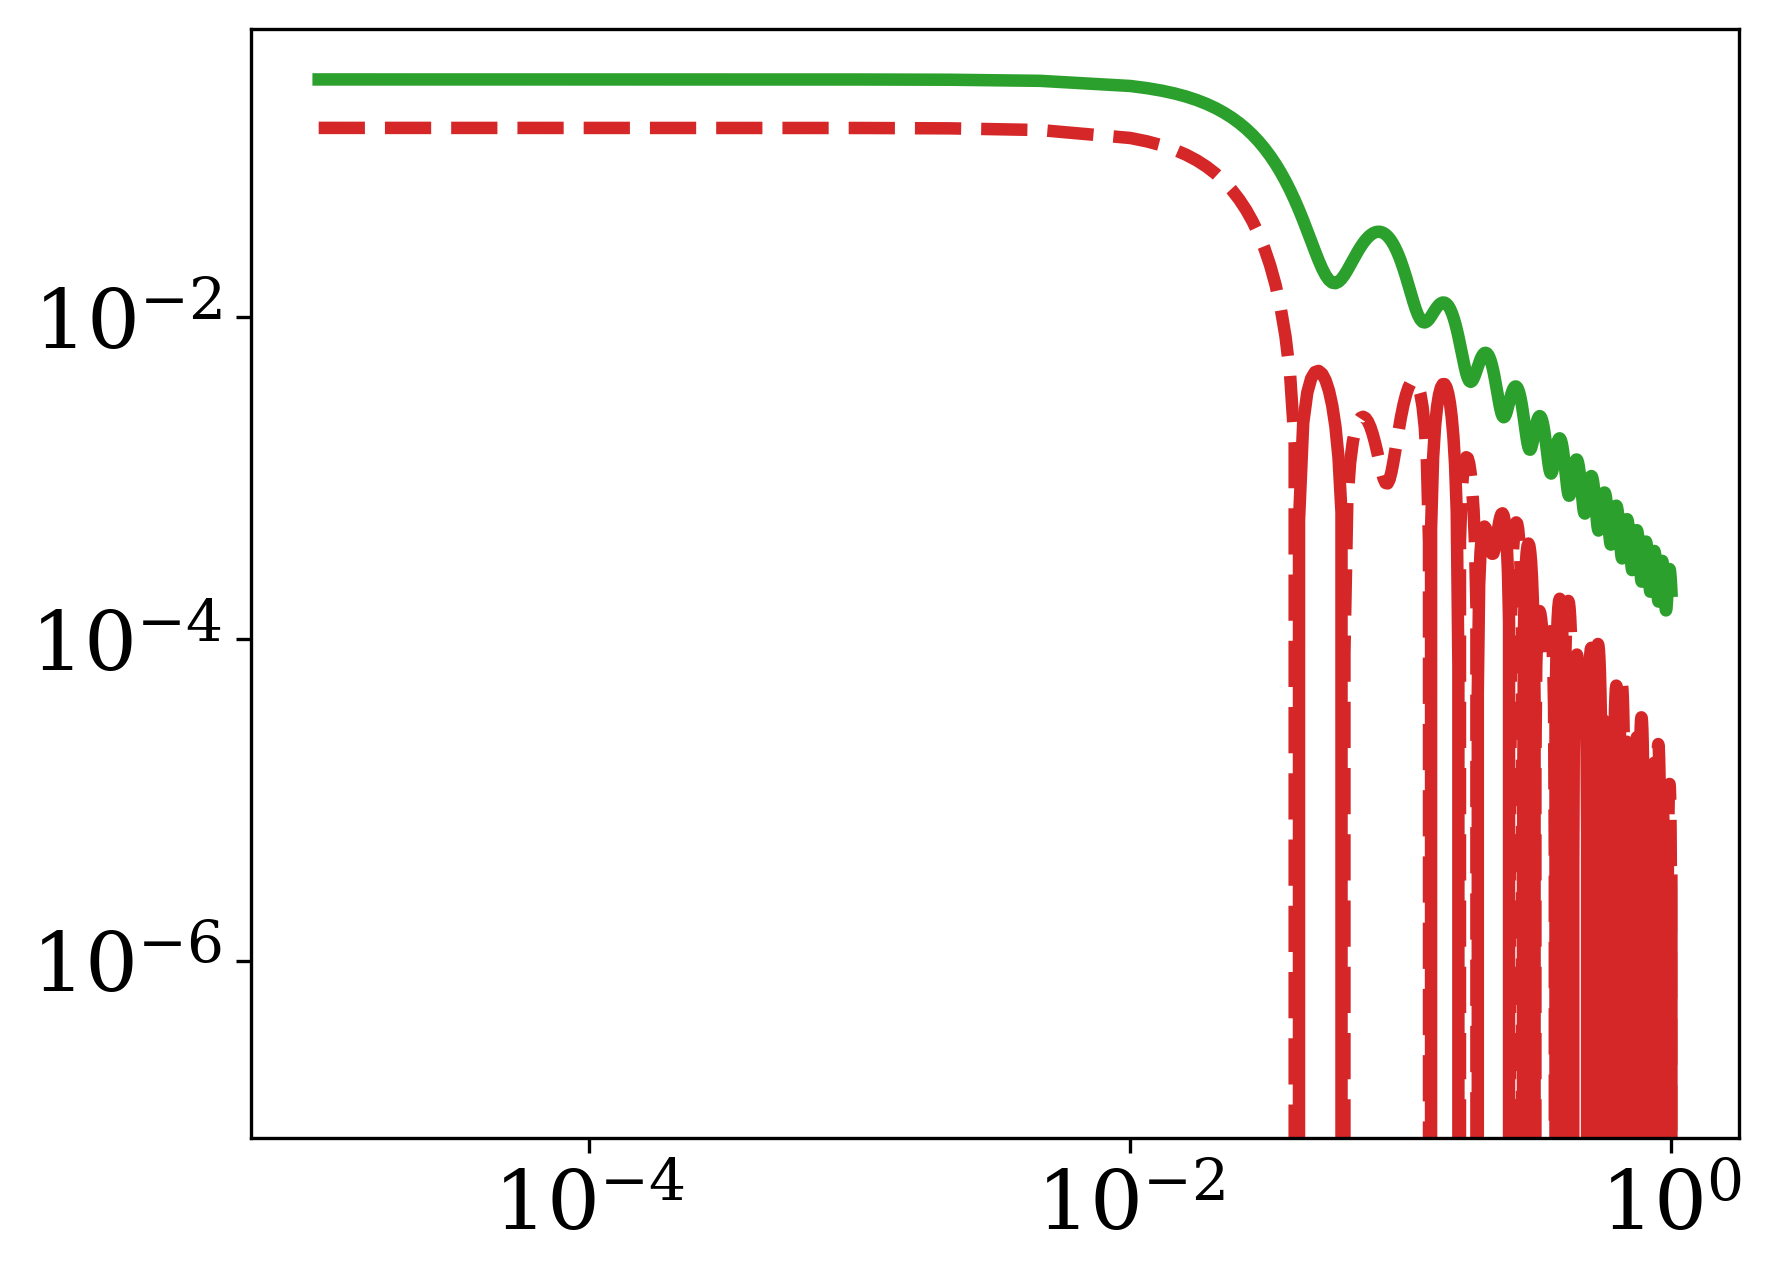

In [432]:
plt.loglog(f_vec,(R1_vec),label='R1',c='C2')
plt.loglog(f_vec,(R2_vec),label='R2',c='C3')
plt.loglog(f_vec,-(R2_vec),label='-R2',c='C3',linestyle='--')

In [433]:
from nest import detectors, overlap,  pls, skymap, nell
import pickle
from tqdm.notebook import tqdm, trange

In [434]:
c1, u1, v1, L, name = detectors.detector('LISA 1', shift_angle=None)
c2, u2, v2, L, name = detectors.detector('LISA 2', shift_angle=None)

f = np.logspace(-5, 0, 200)
R_XX_00 = nell.Rlm_transfer(0, 0, u1, v1, c1, u1, v1, c1, 0, f, 't', L)
R_XY_00 = nell.Rlm_transfer(0, 0, u1, v1, c1, u2, v2, c2, 0, f, 't', L)

R_XX_0 = 2/5 * R_XX_00
R_XY_0 = 2/5 * R_XY_00

In [435]:
print(R_XX_0[0])
print(R_XY_0[0])

0.2999370252215567
-0.149968511140053


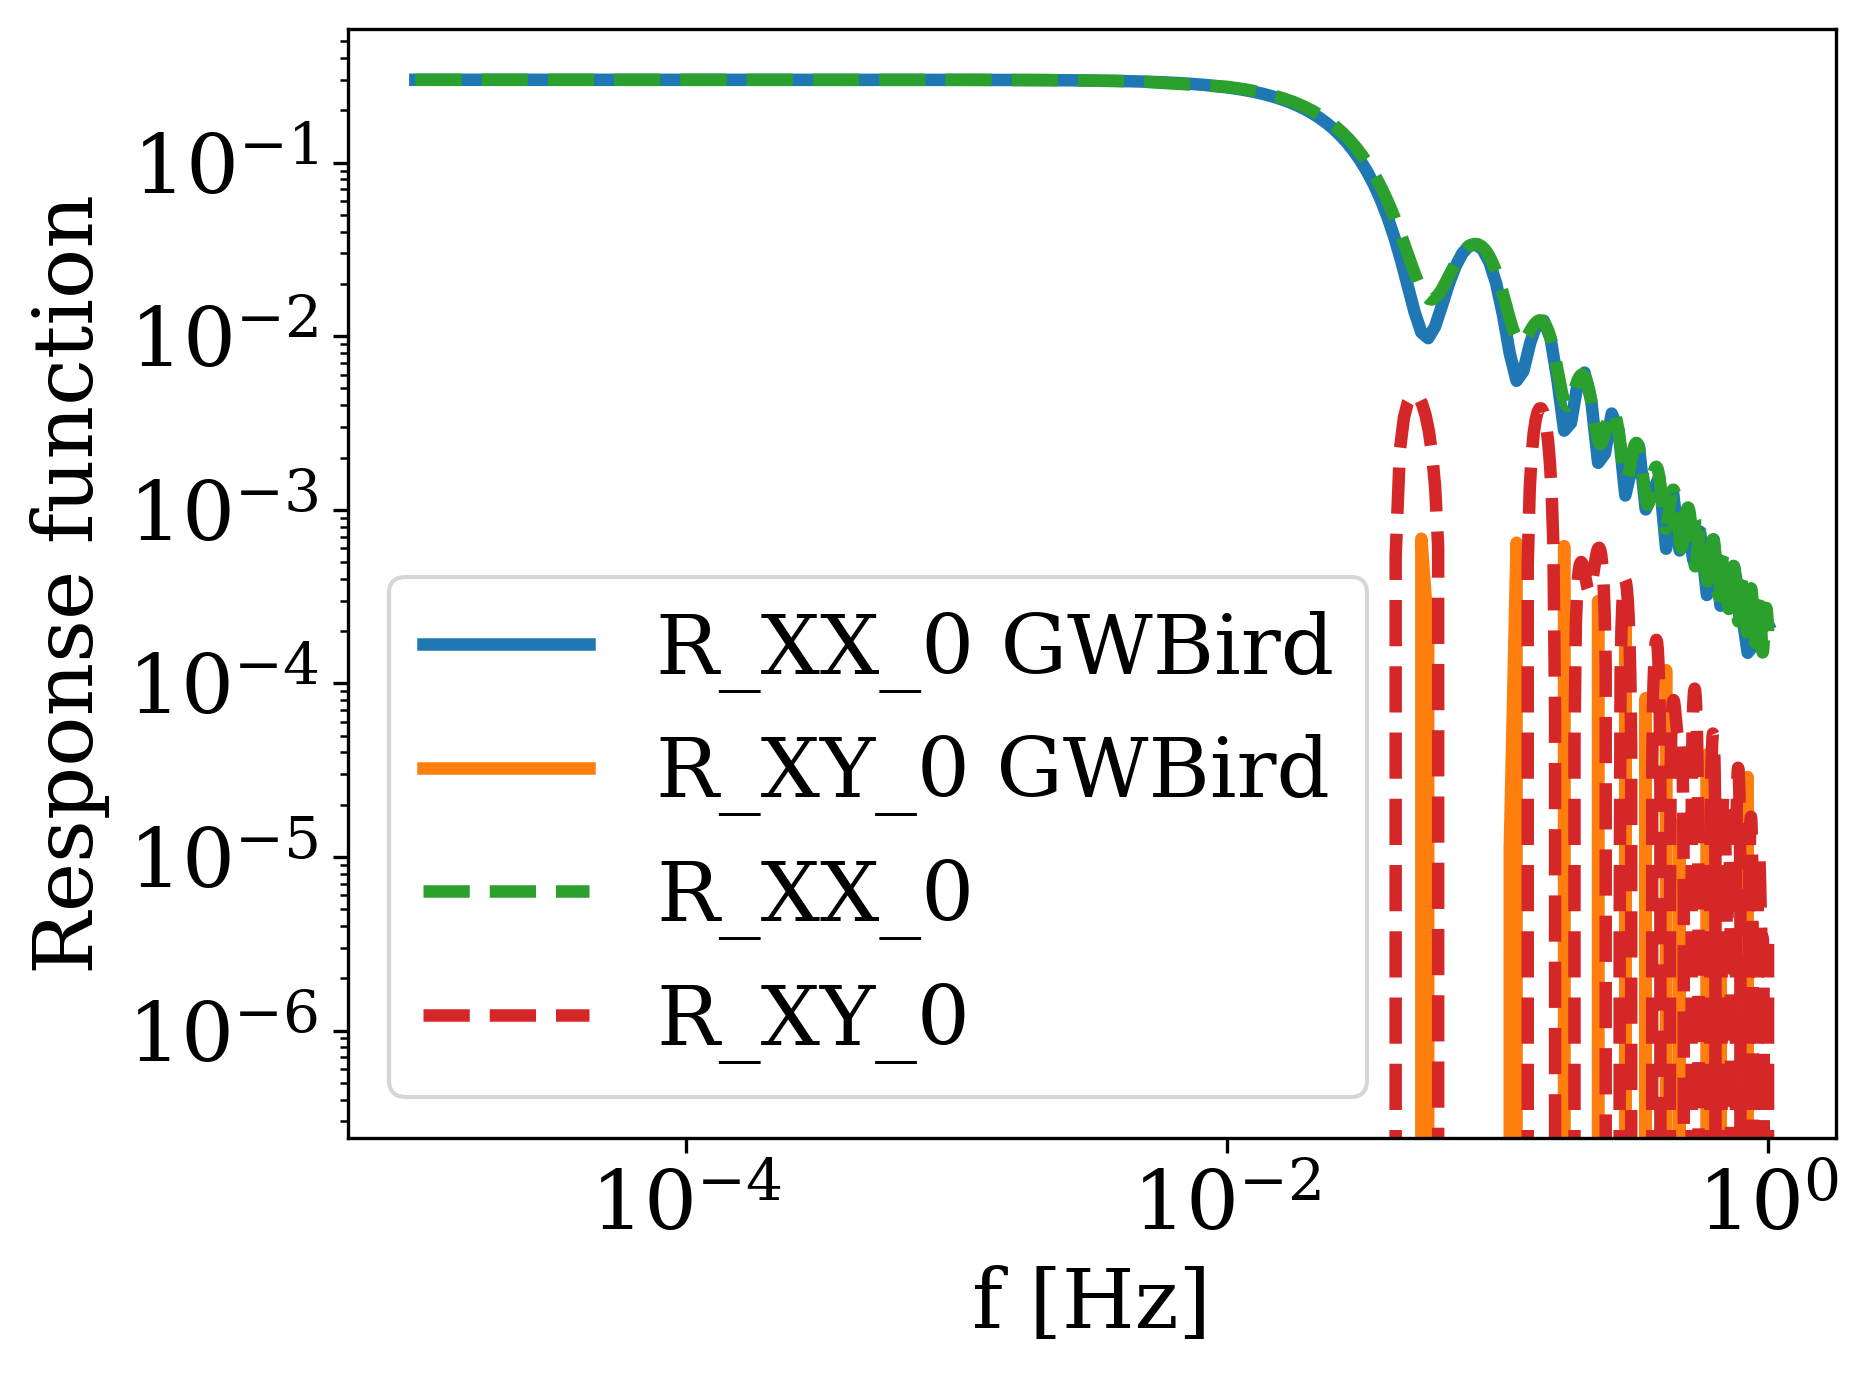

In [436]:
plt.plot(f, R_XX_0, label='R_XX_0 GWBird')
plt.plot(f, R_XY_0, label='R_XY_0 GWBird')
plt.plot(f_vec, R1_vec, label='R_XX_0', linestyle='--')
plt.plot(f_vec, R2_vec, label='R_XY_0', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Response function')
plt.legend()


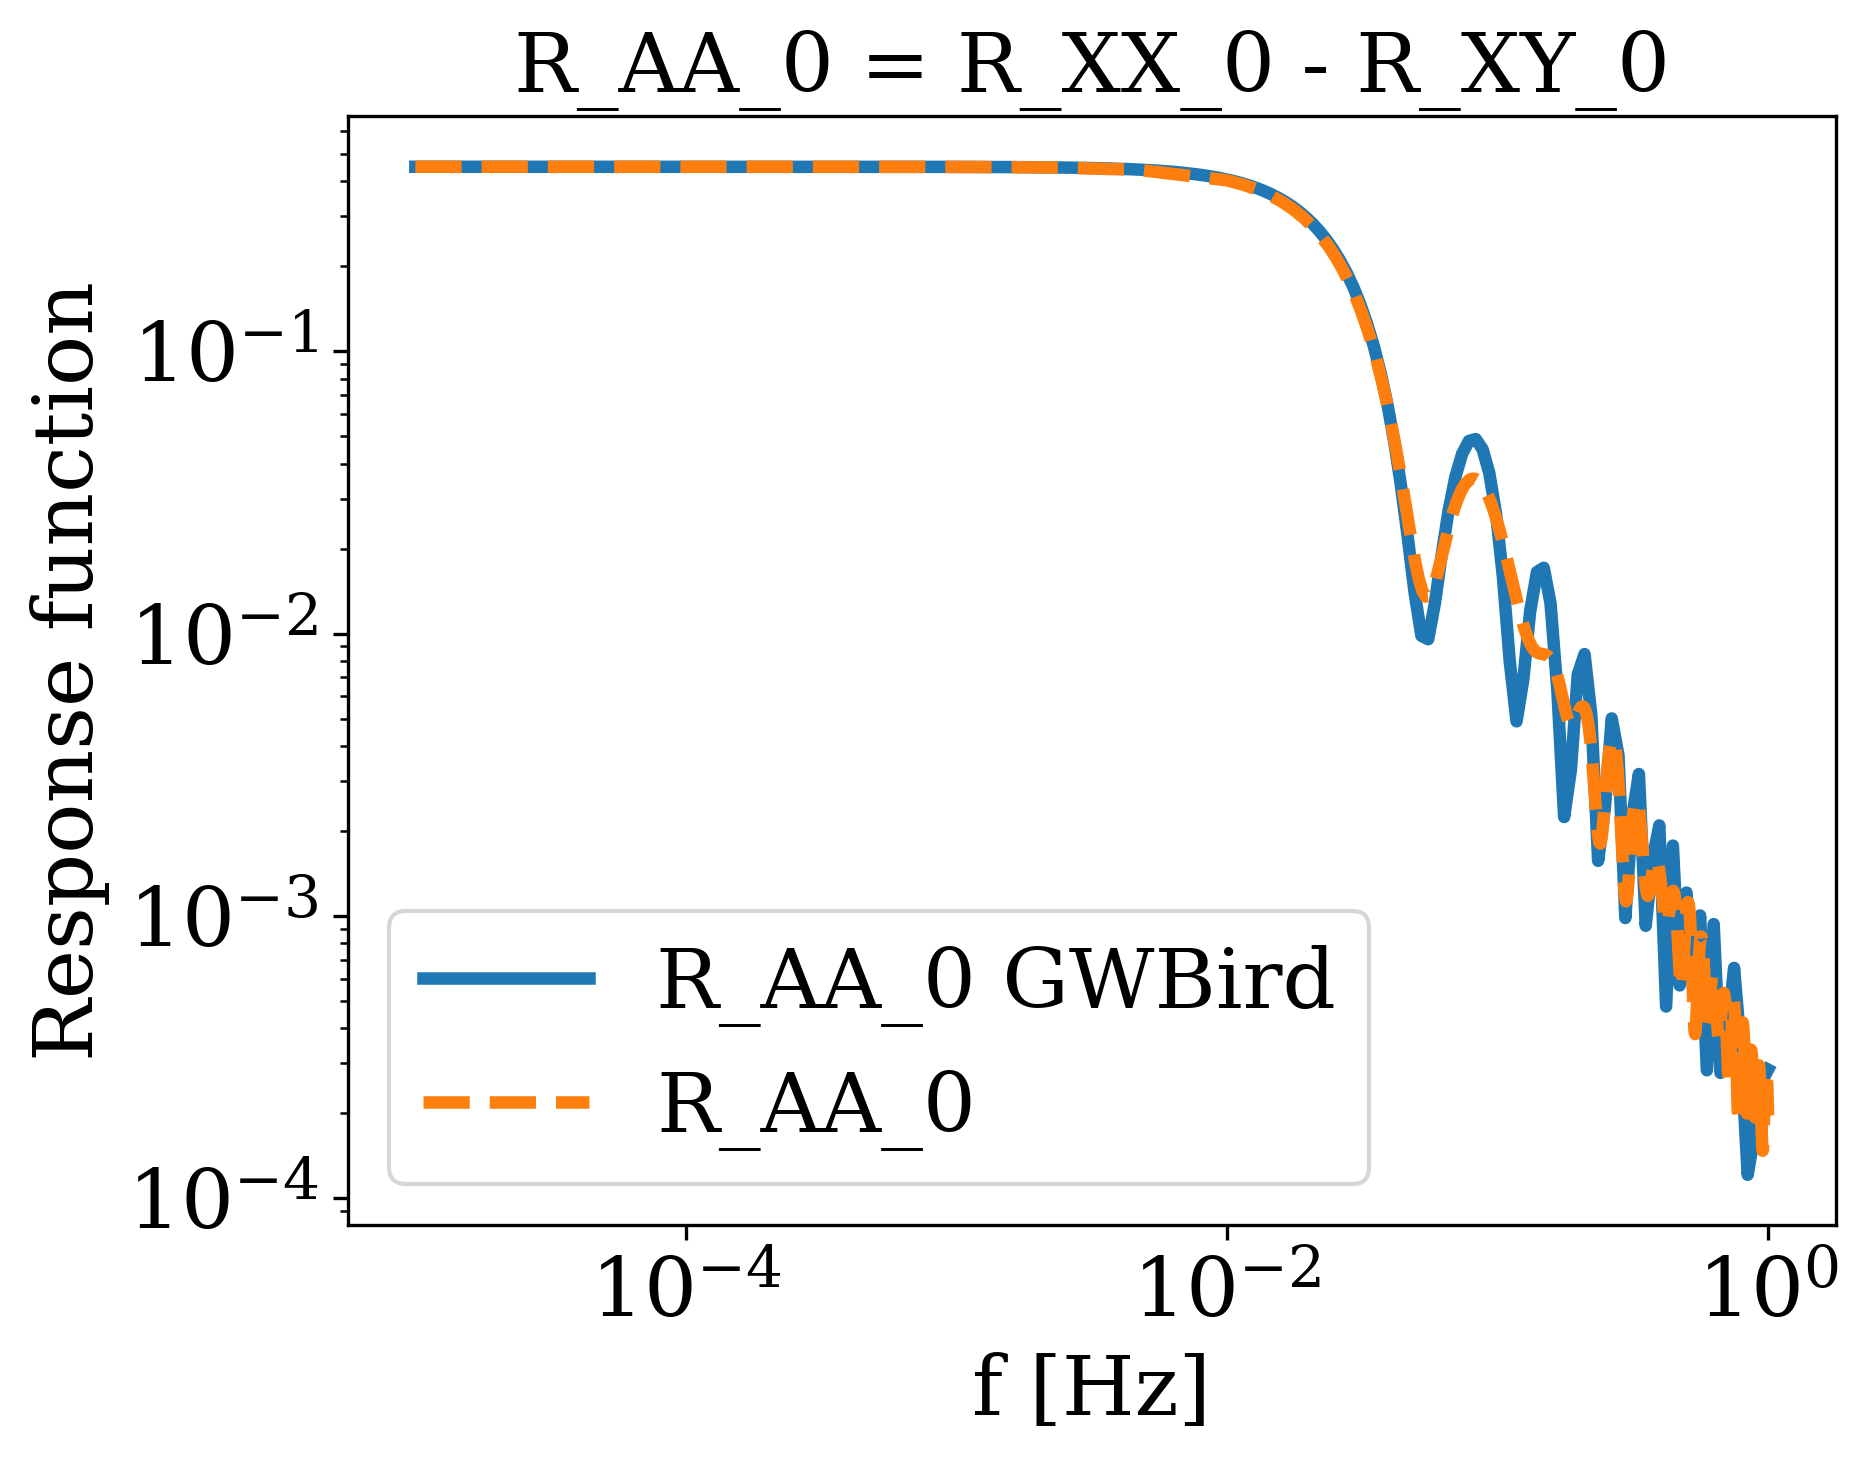

In [437]:
plt.plot(f, R_XX_0 - R_XY_0, label='R_AA_0 GWBird')
plt.plot(f_vec, R1_vec - R2_vec, label='R_AA_0', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Response function')
plt.title('R_AA_0 = R_XX_0 - R_XY_0')
plt.legend()

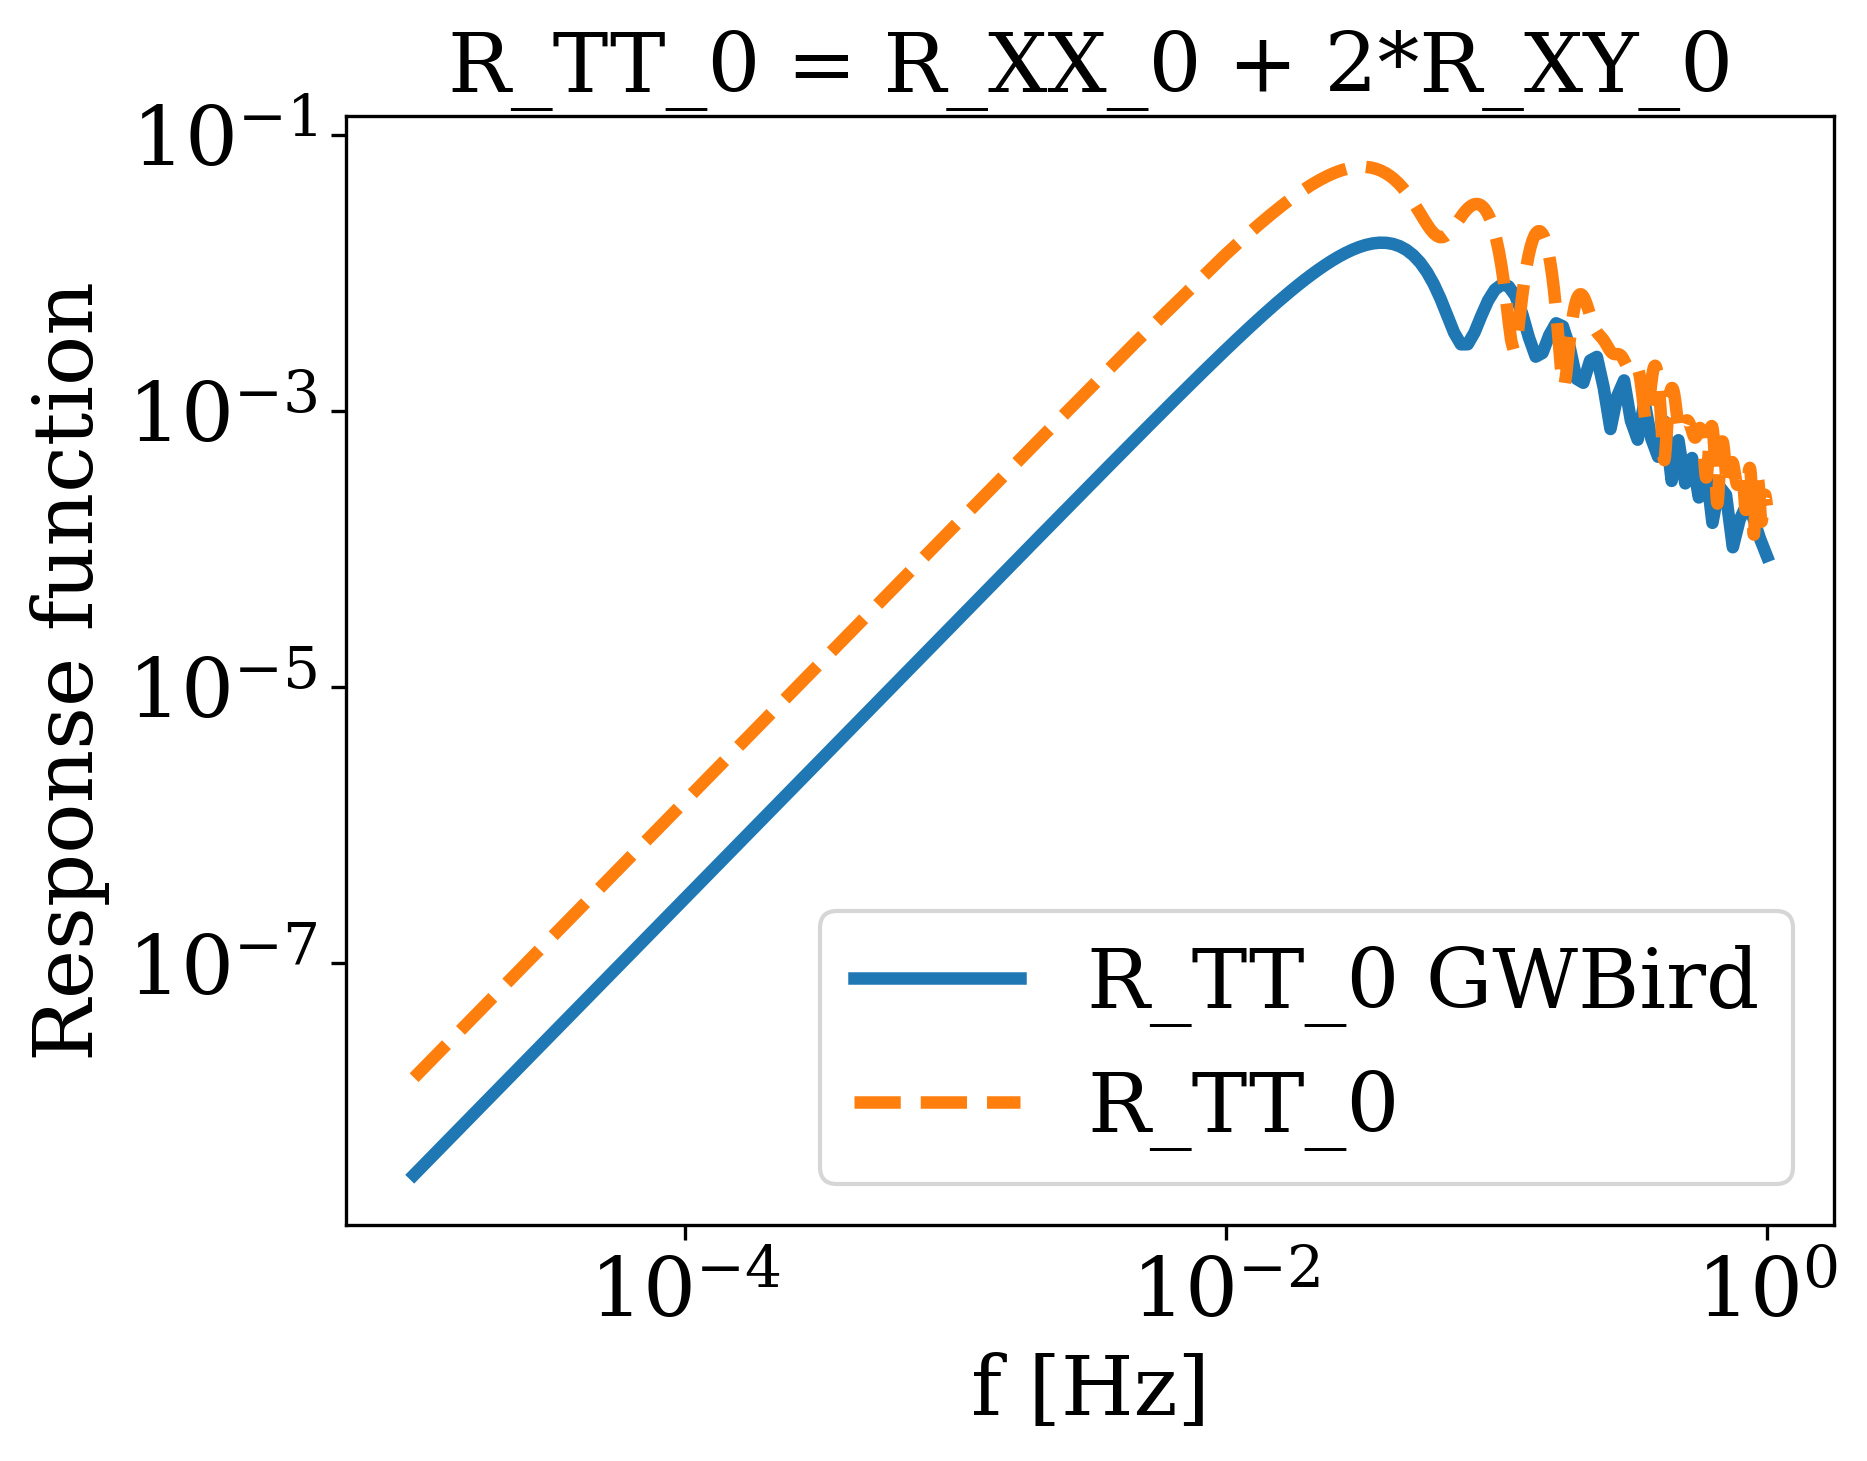

In [438]:
plt.plot(f, R_XX_0 + 2* R_XY_0, label='R_TT_0 GWBird')
plt.plot(f_vec, R1_vec + 2*R2_vec, label='R_TT_0', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Response function')
plt.title('R_TT_0 = R_XX_0 + 2*R_XY_0')
plt.legend()


In [439]:
R1_vec_ell = Response_ell(lA,lA,xA,xA,f,f_star, 0, 0)
R2_vec_ell = Response_ell(lA,lB,xA,xB,f,f_star, 0, 0)

R_XX_ratio = R_XX_0 / R1_vec_ell
R_XY_ratio = R_XY_0 / R2_vec_ell


[0.9999999932016277-1.0899605900163408e-23j
 0.999999992367687 +5.9543995451531286e-23j
 0.9999999914314476-1.7037659531893630e-22j
 0.9999999903803625+1.5814514082794546e-22j
 0.9999999892003428-6.9585913782544054e-22j
 0.9999999878755729+2.8079440083305546e-22j
 0.9999999863882962-3.3519176304453641e-22j
 0.9999999847185789+4.8073176992962455e-22j
 0.9999999828440406-2.6431243102263067e-22j
 0.9999999807395571-3.4012540416556307e-22j
 0.9999999783769213-9.6721257812379456e-23j
 0.9999999757244656+1.1430683315845044e-21j
 0.9999999727466399-1.9815968944817575e-22j
 0.9999999694035303-2.0466675083231870e-22j
 0.999999965650329 +6.0593849228337097e-23j
 0.9999999614367303+3.2887803859655151e-22j
 0.9999999567062591-1.4590391269537129e-21j
 0.9999999513955108-1.0628221319874385e-21j
 0.9999999454333046-1.8586292488070951e-22j
 0.9999999387397274-2.3656098747844587e-22j
 0.9999999312250637+1.0307174075218825e-21j
 0.9999999227885925-1.3338716036894295e-21j
 0.9999999133172369+8.0795343094

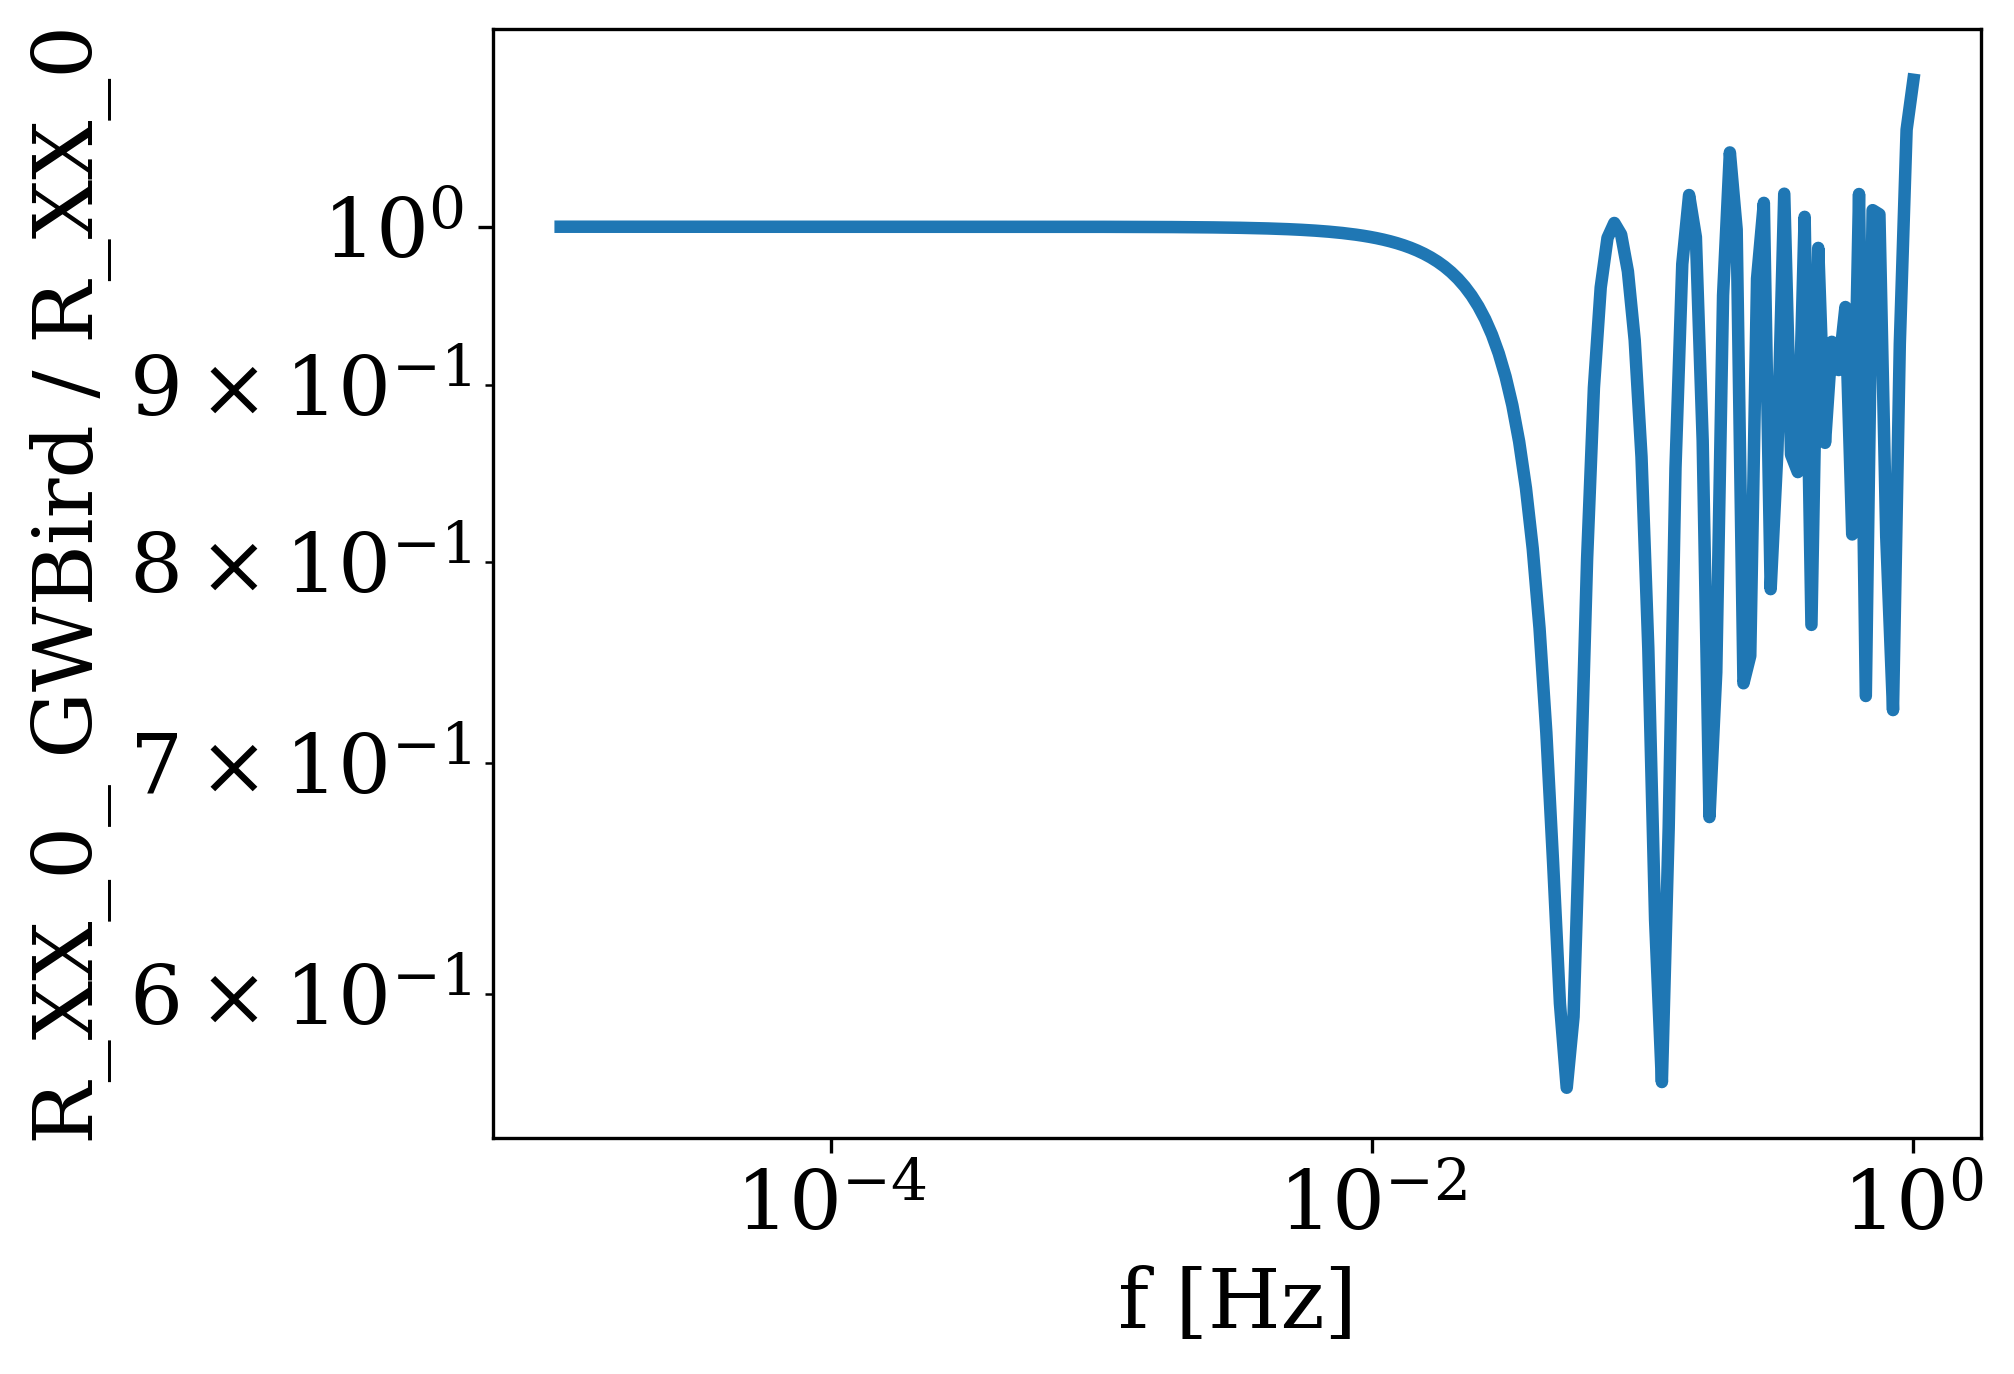

In [440]:
plt.loglog(f, R_XX_ratio)
plt.xlabel('f [Hz]')
plt.ylabel('R_XX_0_ GWBird / R_XX_0')

np.set_printoptions(precision=20)

print(R_XX_ratio)

[ 1.0000000041132315e+00-1.6958082703335178e-04j
  1.0000000046177926e+00-1.7968109165481007e-04j
  1.0000000051842473e+00-1.9038292987844633e-04j
  1.0000000058201874e+00-2.0172217154165015e-04j
  1.0000000065341370e+00-2.1373678051444652e-04j
  1.0000000073356656e+00-2.2646698180307337e-04j
  1.0000000082355156e+00-2.3995539622390327e-04j
  1.0000000092457486e+00-2.5424718309862419e-04j
  1.0000000103799047e+00-2.6939019144841625e-04j
  1.0000000116531853e+00-2.8543512019335734e-04j
  1.0000000130826570e+00-3.0243568789340390e-04j
  1.0000000146874788e+00-3.2044881259927745e-04j
  1.0000000164891607e+00-3.3953480241540442e-04j
  1.0000000185118514e+00-3.5975755741296311e-04j
  1.0000000207826620e+00-3.8118478356905444e-04j
  1.0000000233320285e+00-4.0388821944832657e-04j
  1.0000000261941211e+00-4.2794387638601179e-04j
  1.0000000294073017e+00-4.5343229297658530e-04j
  1.0000000330146368e+00-4.8043880472011744e-04j
  1.0000000370644779e+00-5.0905382972920383e-04j
  1.0000000416111068

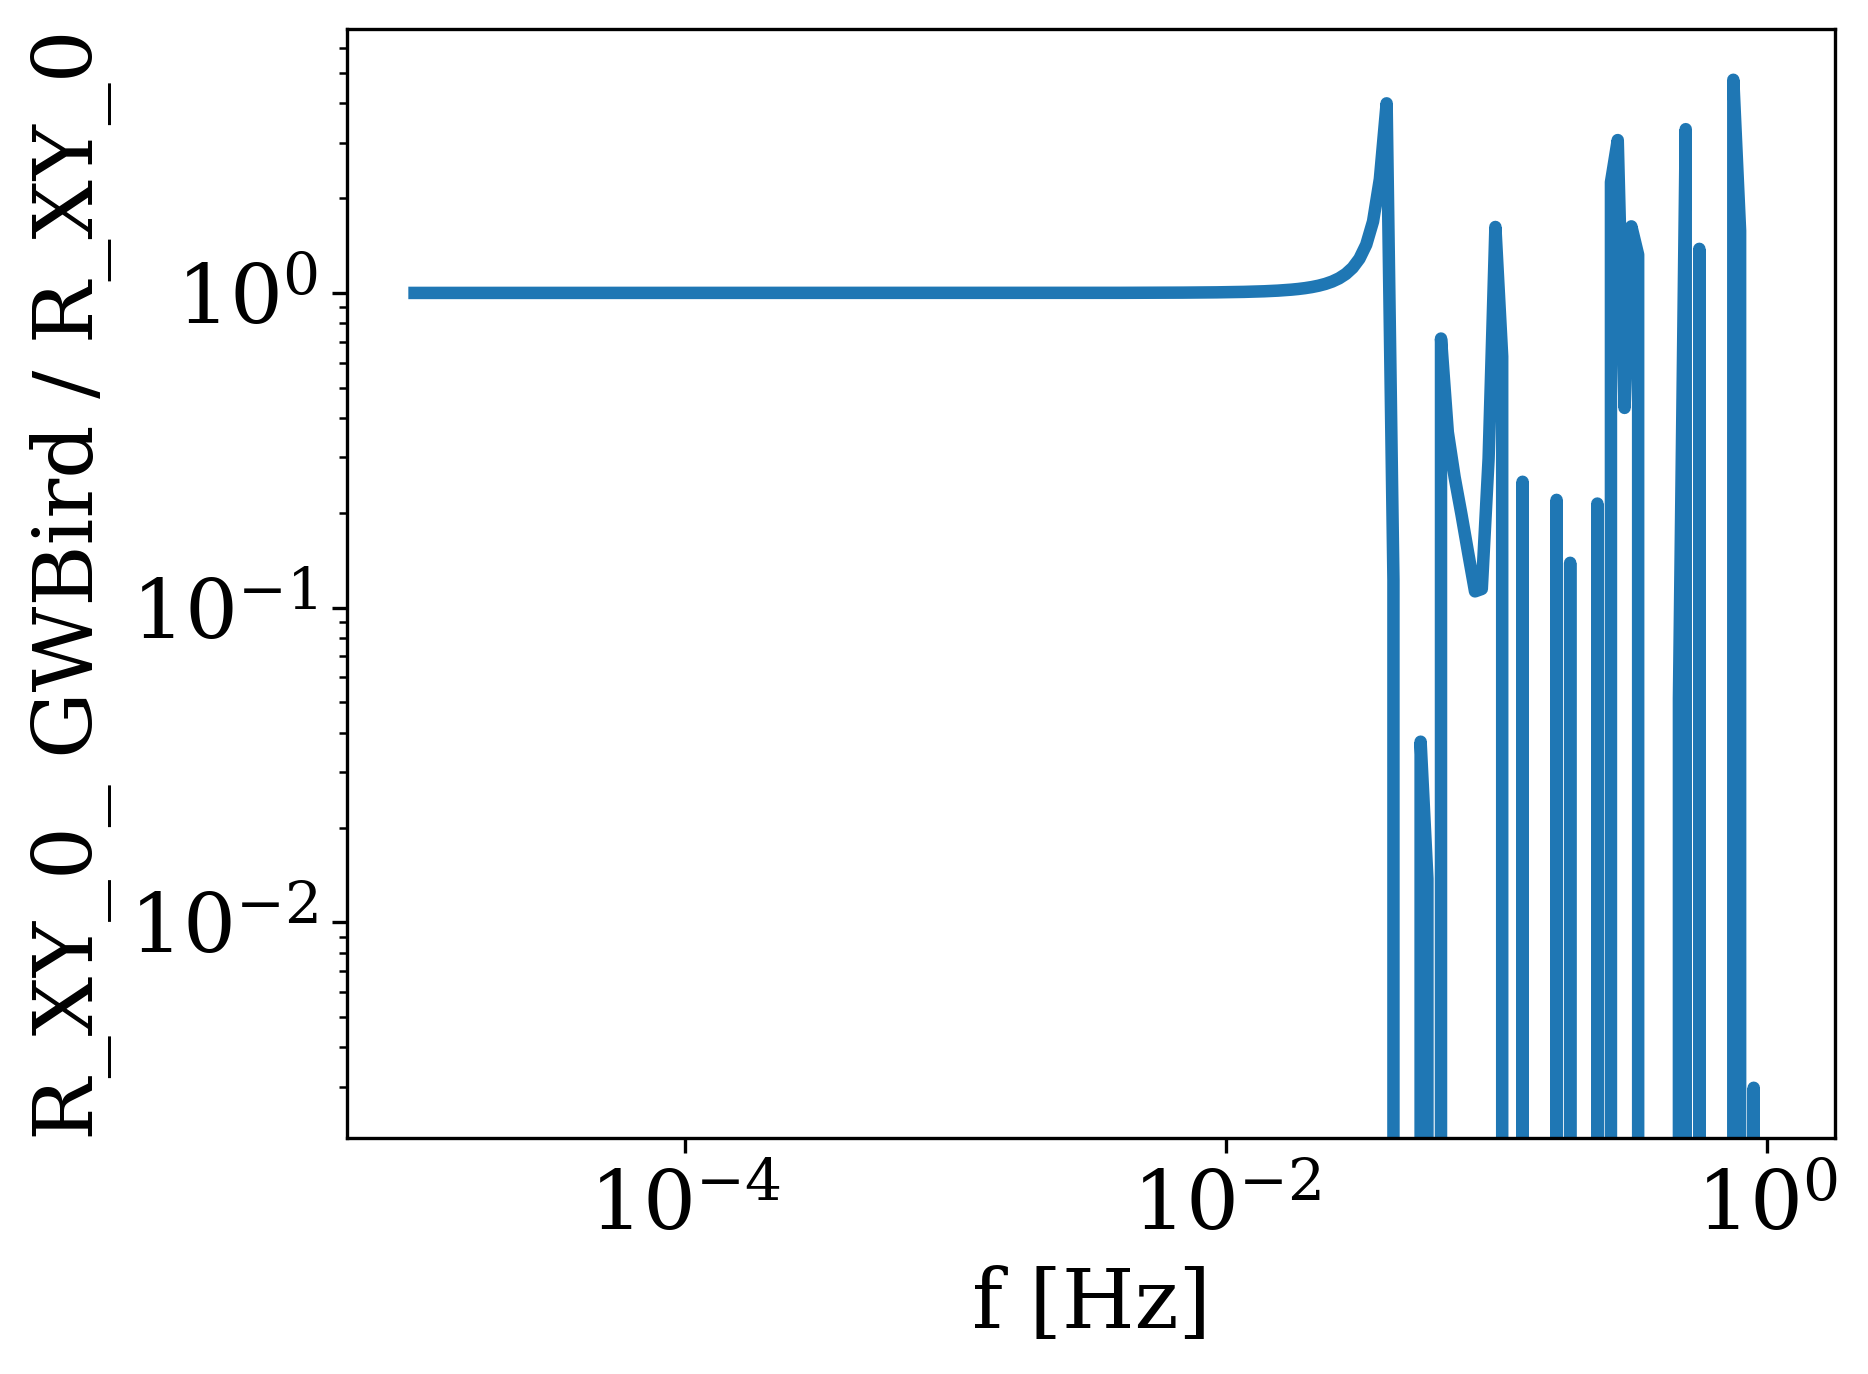

In [441]:
plt.loglog(f, R_XY_ratio)
plt.xlabel('f [Hz]')
plt.ylabel('R_XY_0_ GWBird / R_XY_0')

print(R_XY_ratio)



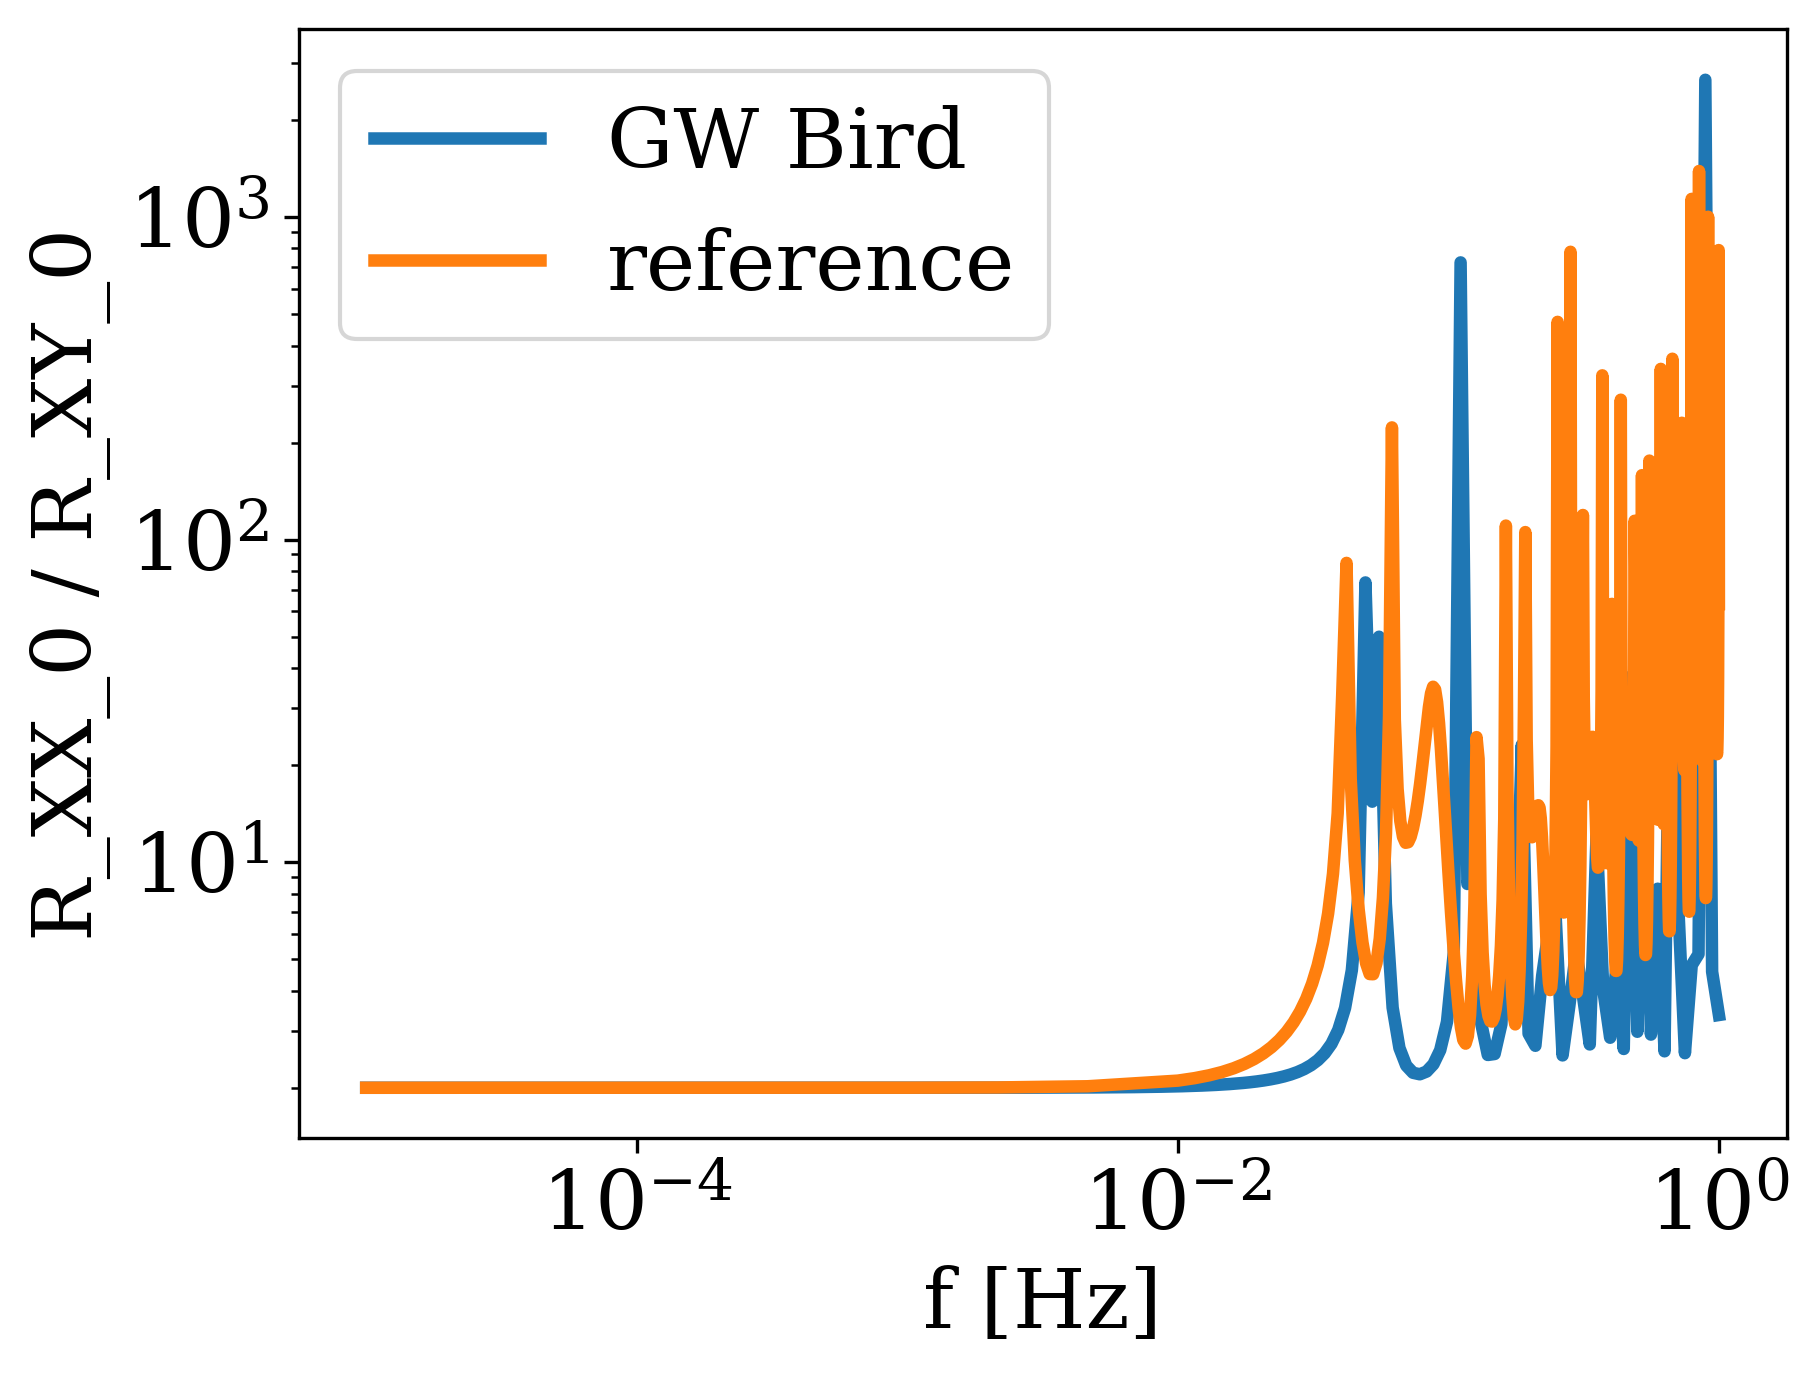

In [442]:
GWBird_ratio = R_XX_0 / R_XY_0
ratio = R1_vec / R2_vec

plt.loglog(f, np.abs(GWBird_ratio), label='GW Bird')
plt.loglog(f_vec, np.abs(ratio), label='reference')
plt.xlabel('f [Hz]')
plt.ylabel('R_XX_0 / R_XY_0')
plt.legend()


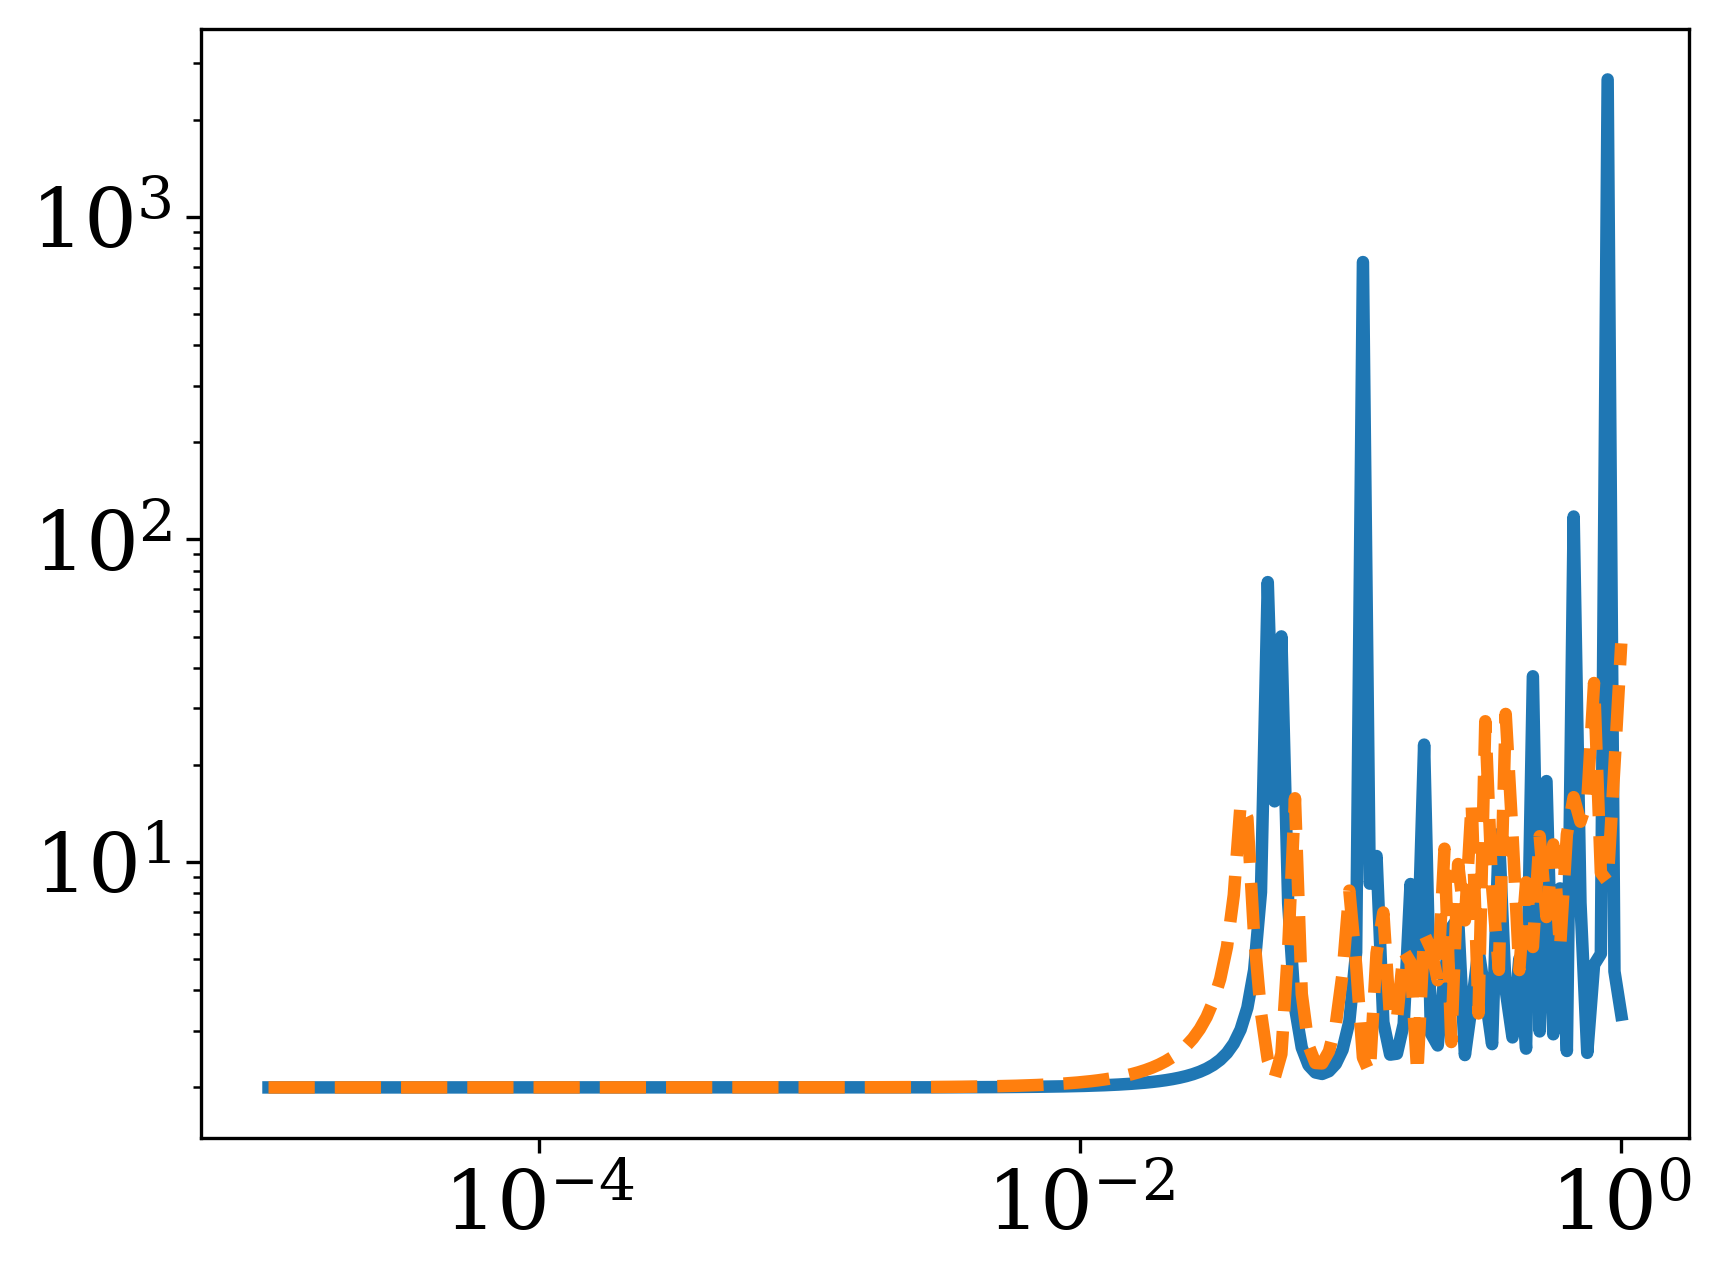

In [443]:
# plottare il rapporto 

plt.plot(f, np.abs(R_XX_0/R_XY_0))
plt.plot(f, np.abs(R1_vec_ell/R2_vec_ell), linestyle='--')
plt.xscale('log')
plt.yscale('log')


In [444]:
print(R_XX_0[0], R1_vec_ell[0])

0.2999370252215567 (0.29993702726064025+3.2691954142327546e-24j)


Text(0, 0.5, 'R_TT GWBird / R_TT')

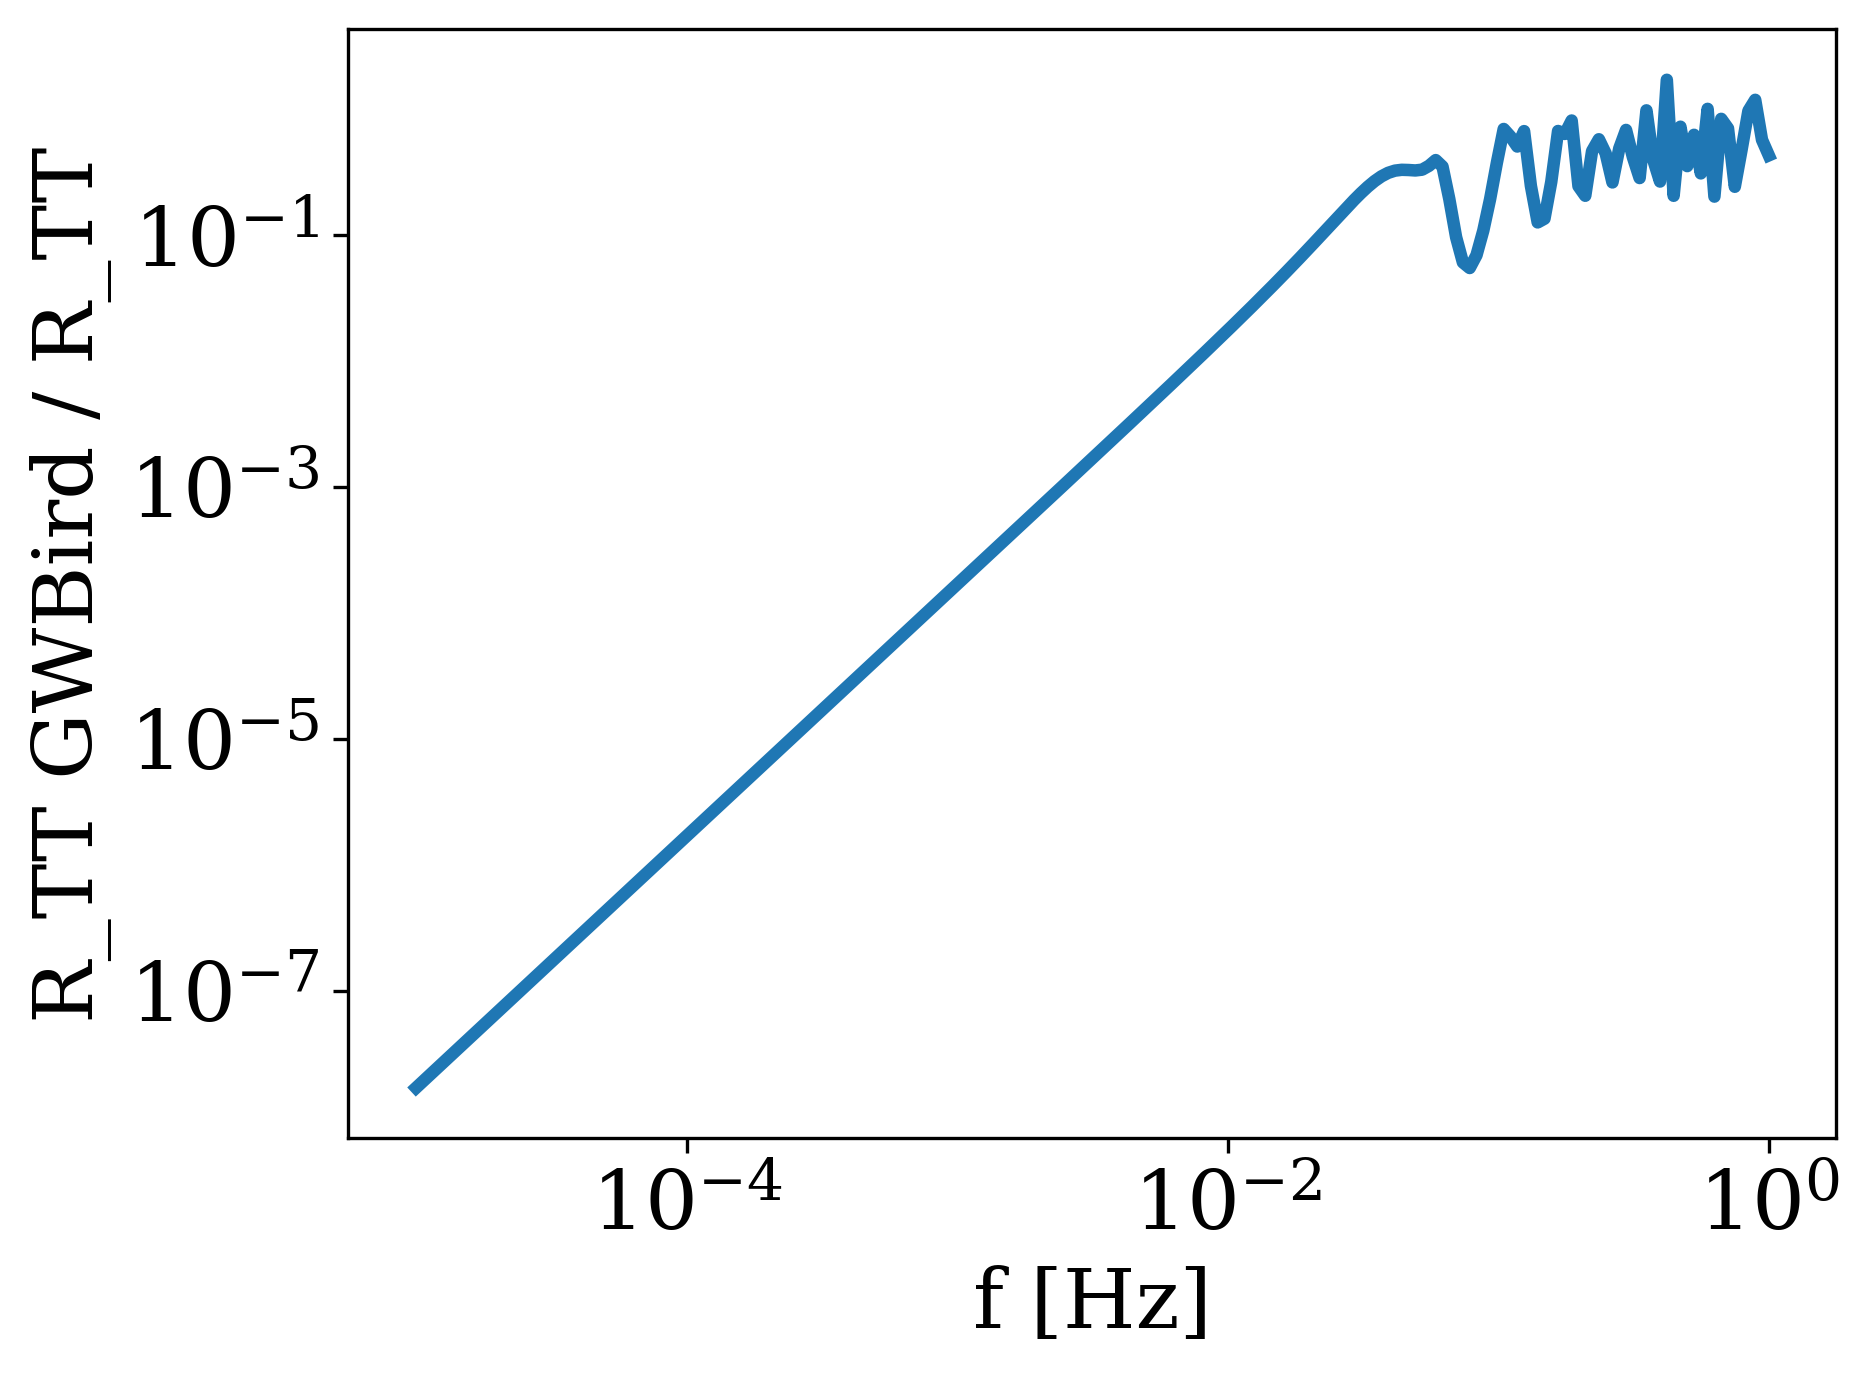

In [445]:
R_TT_GWBird = R_XX_0 + 2 * R_XY_0
R_TT = R1_vec_ell + 2 * R2_vec_ell

plt.loglog(f, R_TT_GWBird/R_TT)
plt.xlabel('f [Hz]')
plt.ylabel('R_TT GWBird / R_TT')


Text(0, 0.5, 'R')

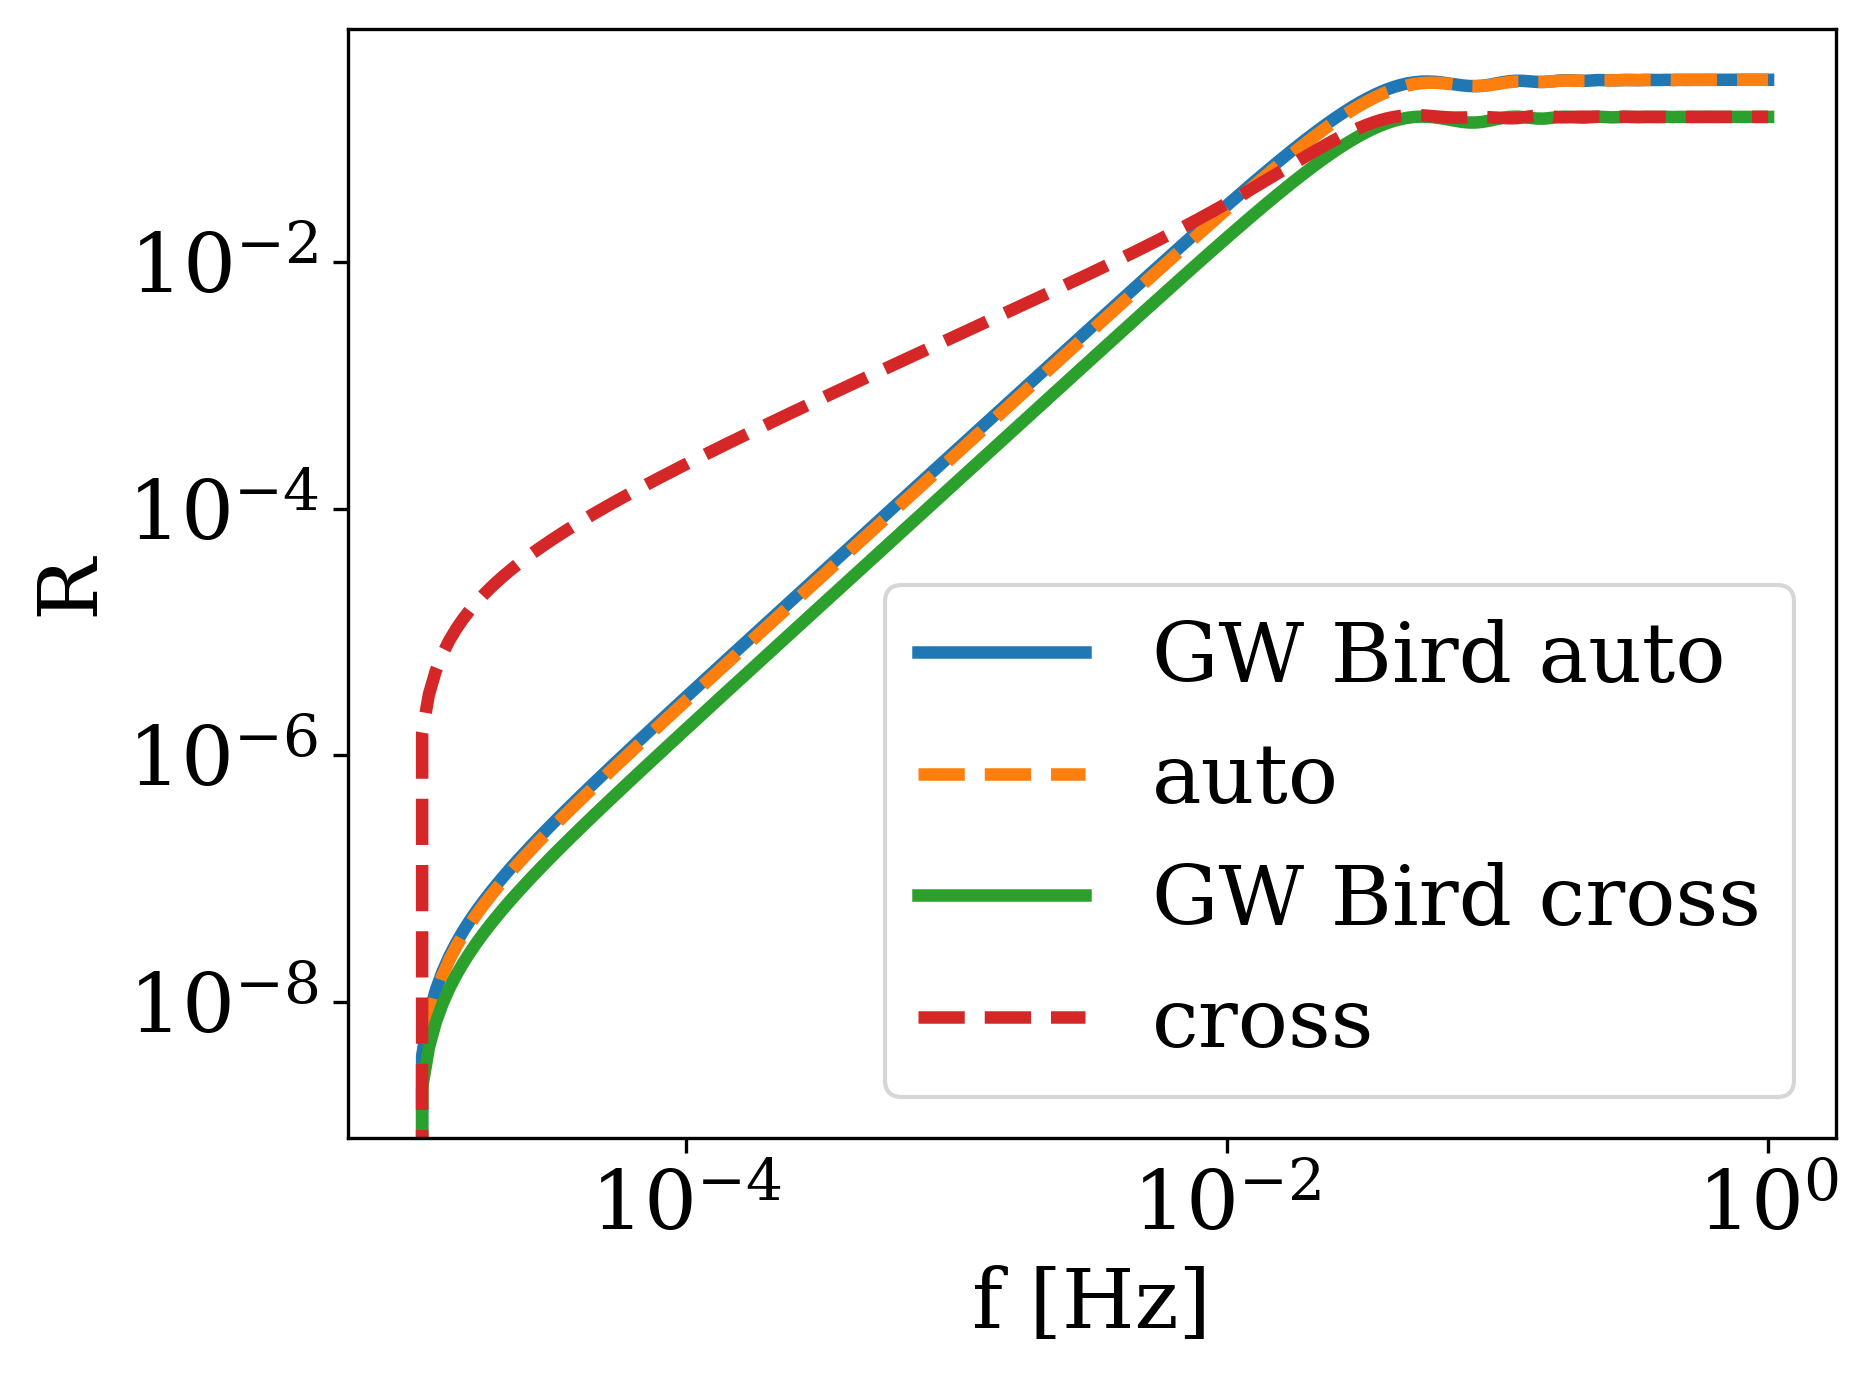

In [446]:
ref_GWBird_auto = R_XX_0[0] - R_XX_0
ref_auto = R1_vec_ell[0] - R1_vec_ell
ref_GWBird_cross = R_XY_0[0] - R_XY_0
ref_cross = R2_vec_ell[0] - R2_vec_ell

plt.loglog(f, ref_GWBird_auto, label='GW Bird auto')
plt.loglog(f, ref_auto, label='auto', linestyle='--')
plt.loglog(f, np.abs(ref_GWBird_cross), label='GW Bird cross')
plt.loglog(f, np.abs(ref_cross), label='cross', linestyle='--')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('R')



Text(0, 0.5, 'differences')

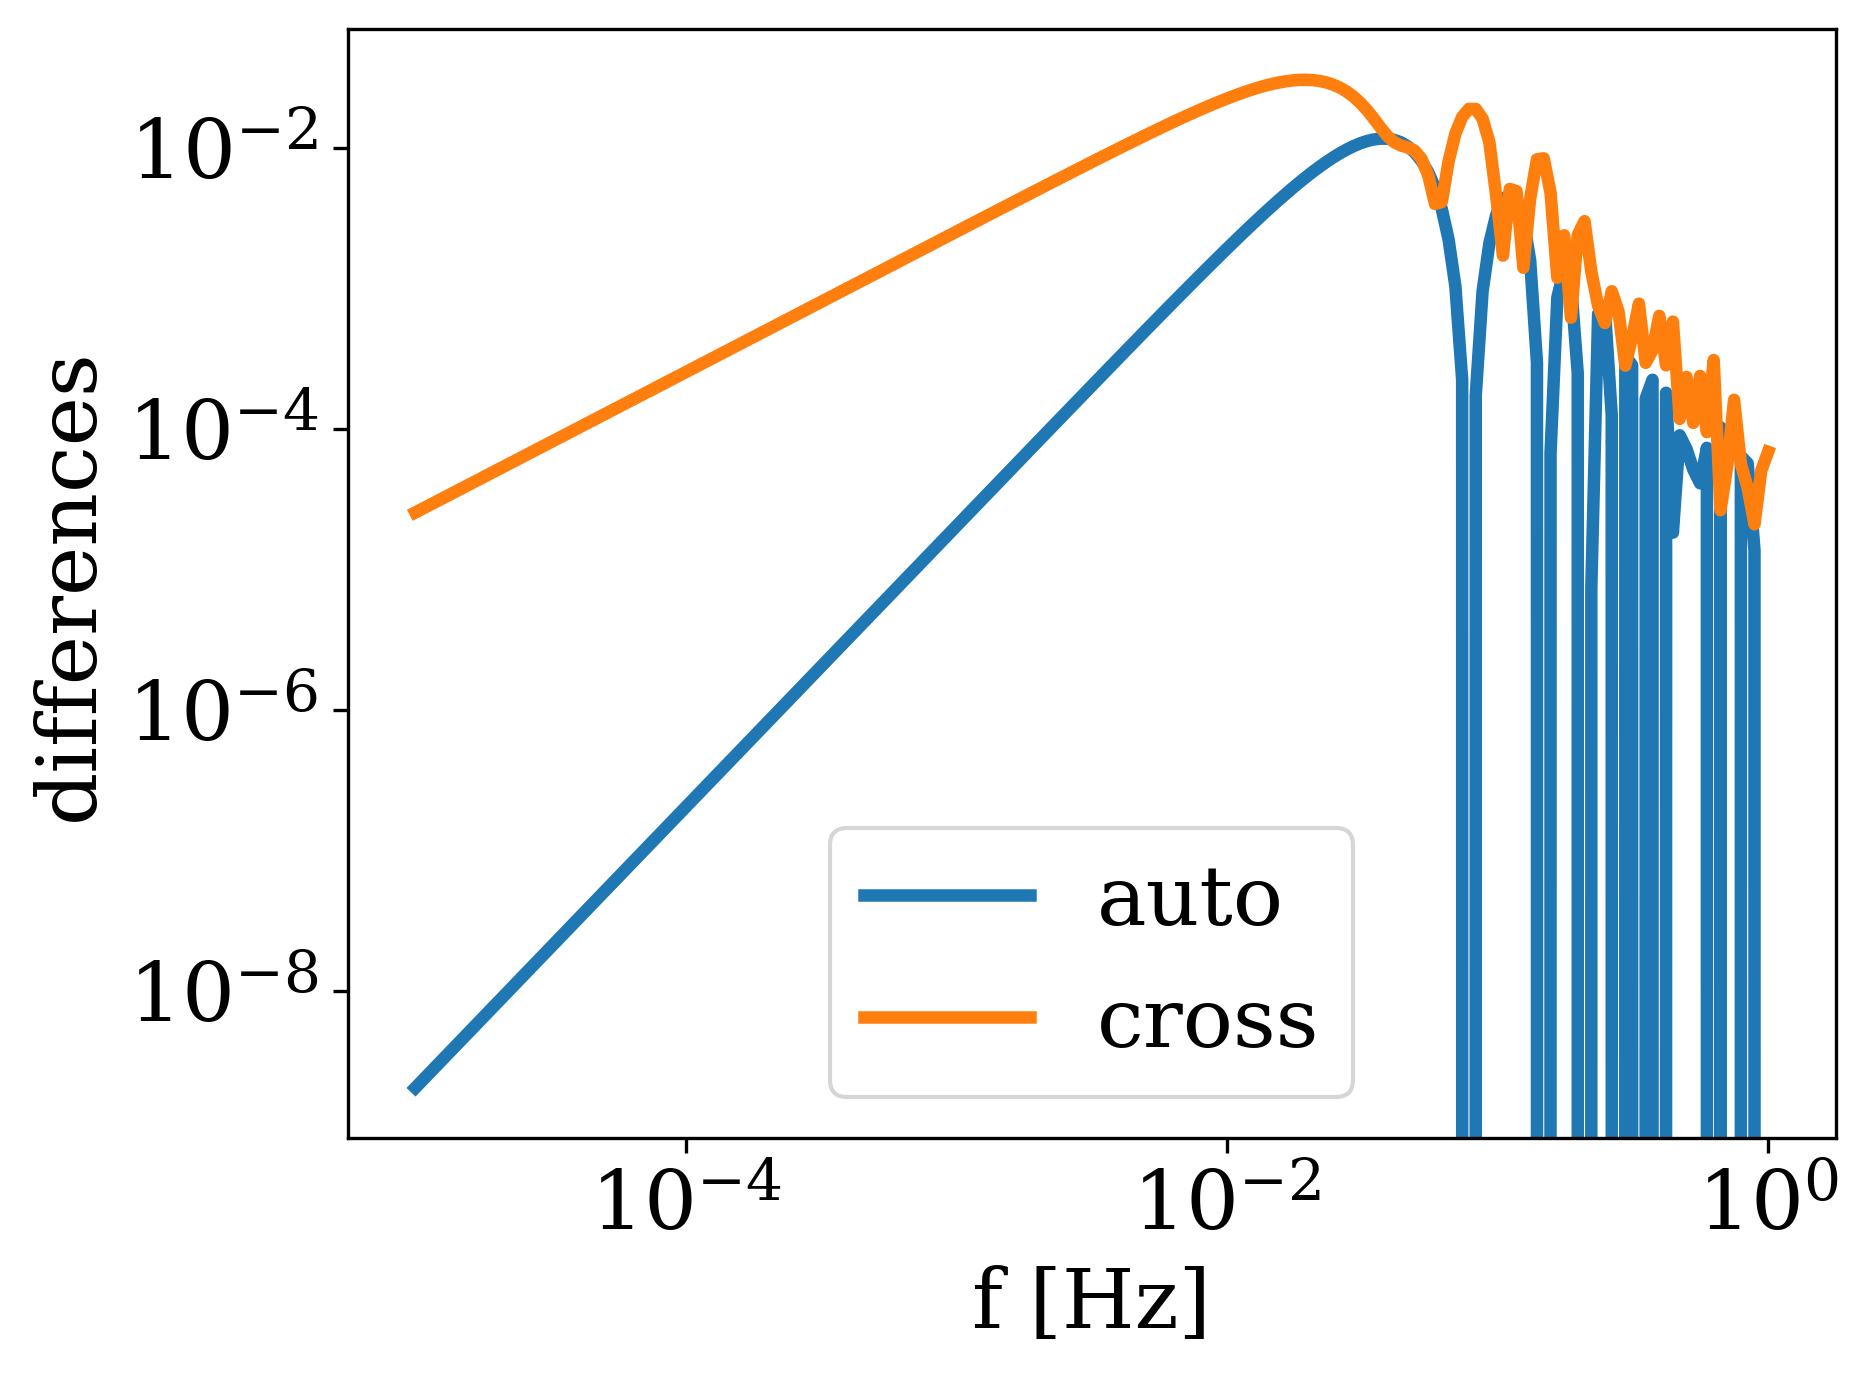

In [447]:
diff_auto = R1_vec_ell - R_XX_0
diff_cross = R2_vec_ell - R_XY_0

plt.loglog(f, diff_auto, label='auto')
plt.loglog(f, np.abs(diff_cross), label='cross')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('differences')


Text(0, 0.5, 'relative differences')

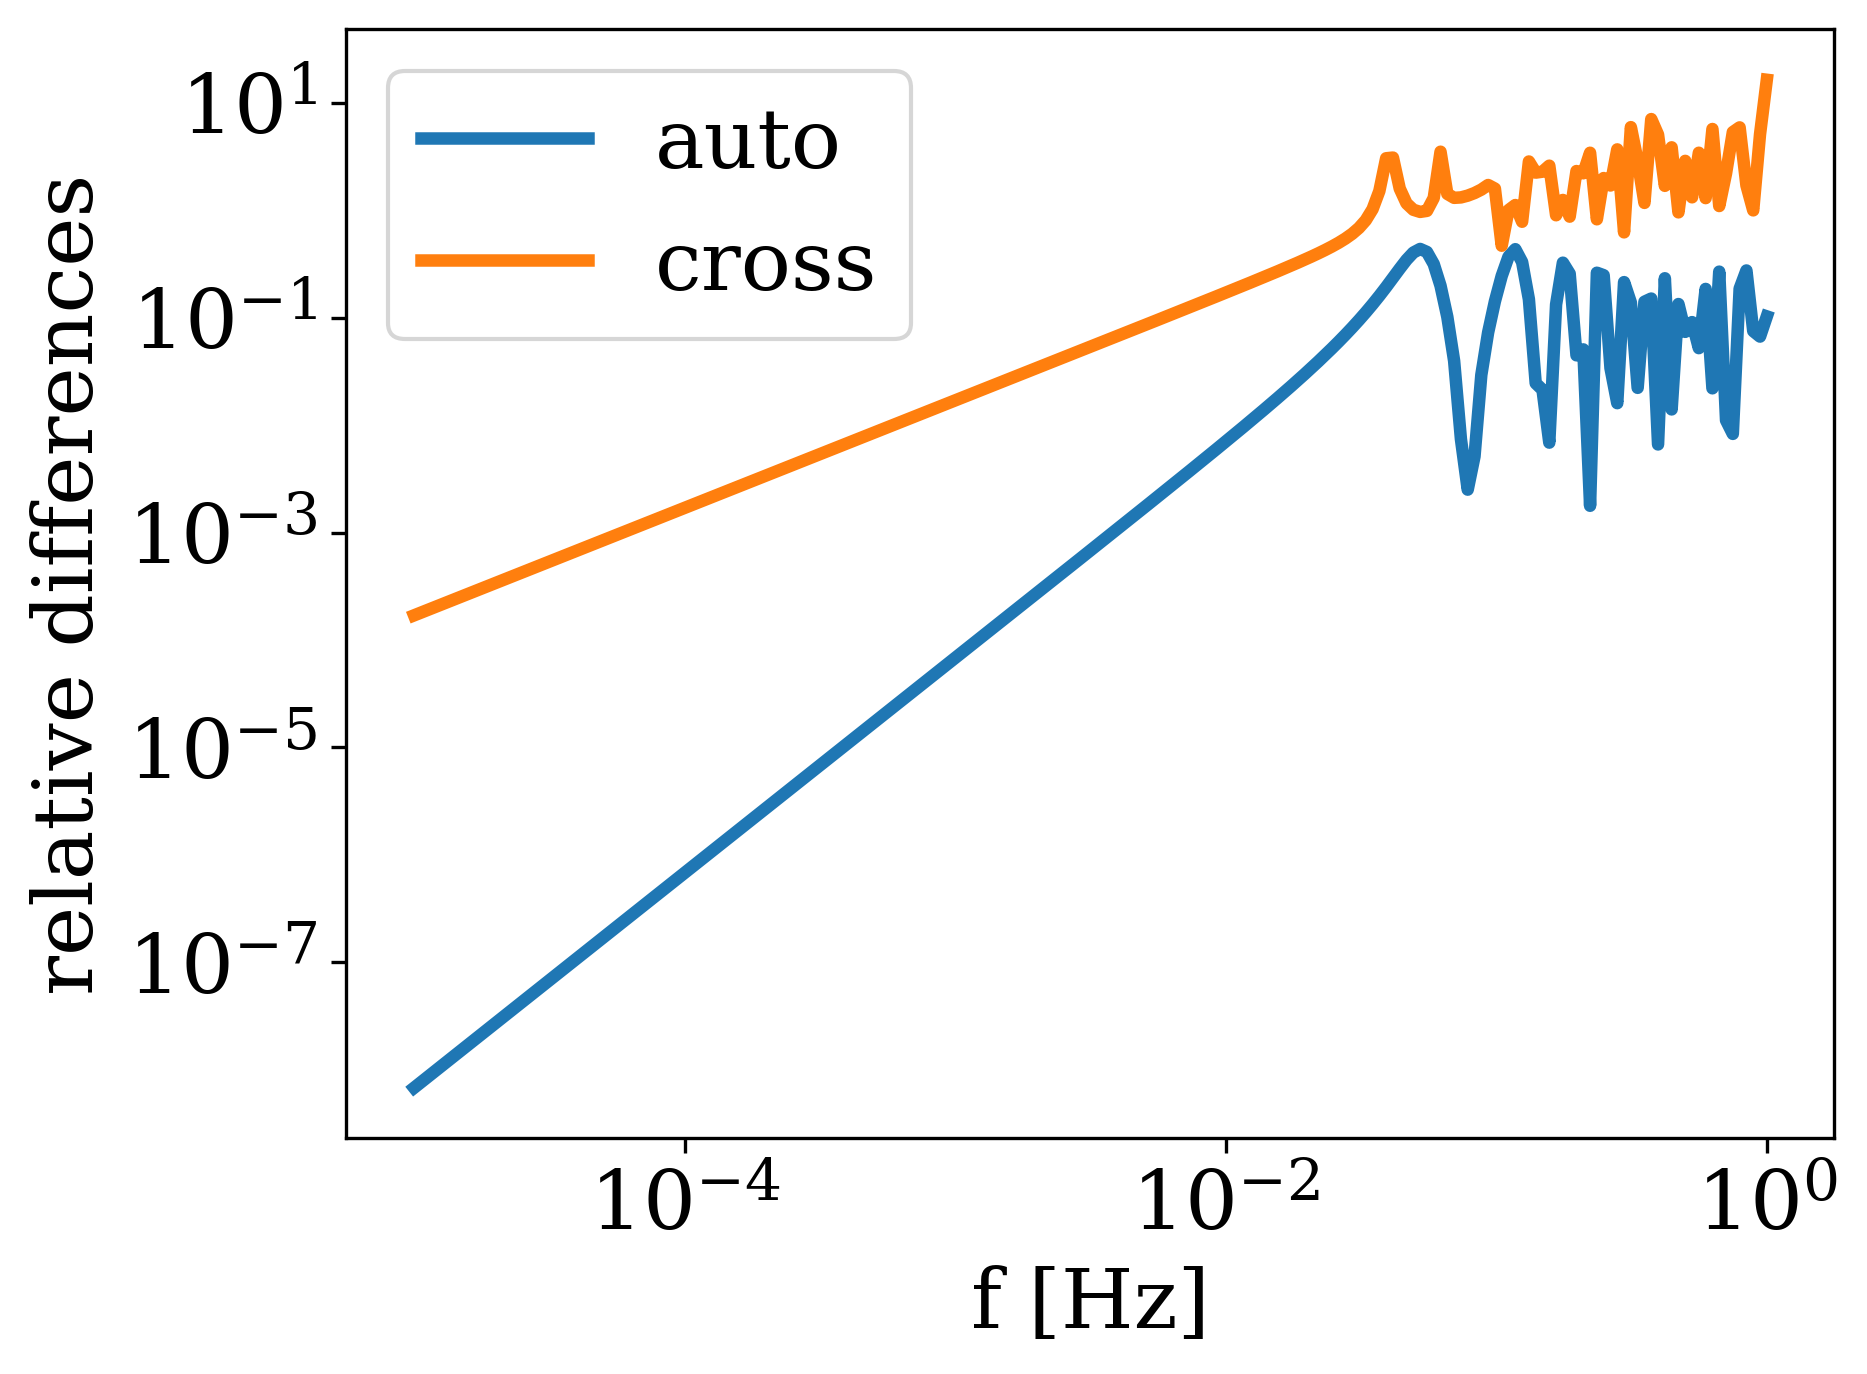

In [448]:
# relative differences
diffrel_auto =( R1_vec_ell - R_XX_0) / R1_vec_ell
diffrel_cross = (R2_vec_ell - R_XY_0) / R2_vec_ell

plt.loglog(f, np.abs(diffrel_auto), label='auto')
plt.loglog(f, np.abs(diffrel_cross), label='cross')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('relative differences')

/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_28460/1374006137.py:23: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  R_XX_0_prime = derivative(R_XX_0_func, f_interp, dx=1e-6)
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_28460/1374006137.py:24: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  R_XY_0_prime = derivative(R_XY_0_func, f_interp, dx=1e-6)
/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_28460/1374006137.py:34: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider usi

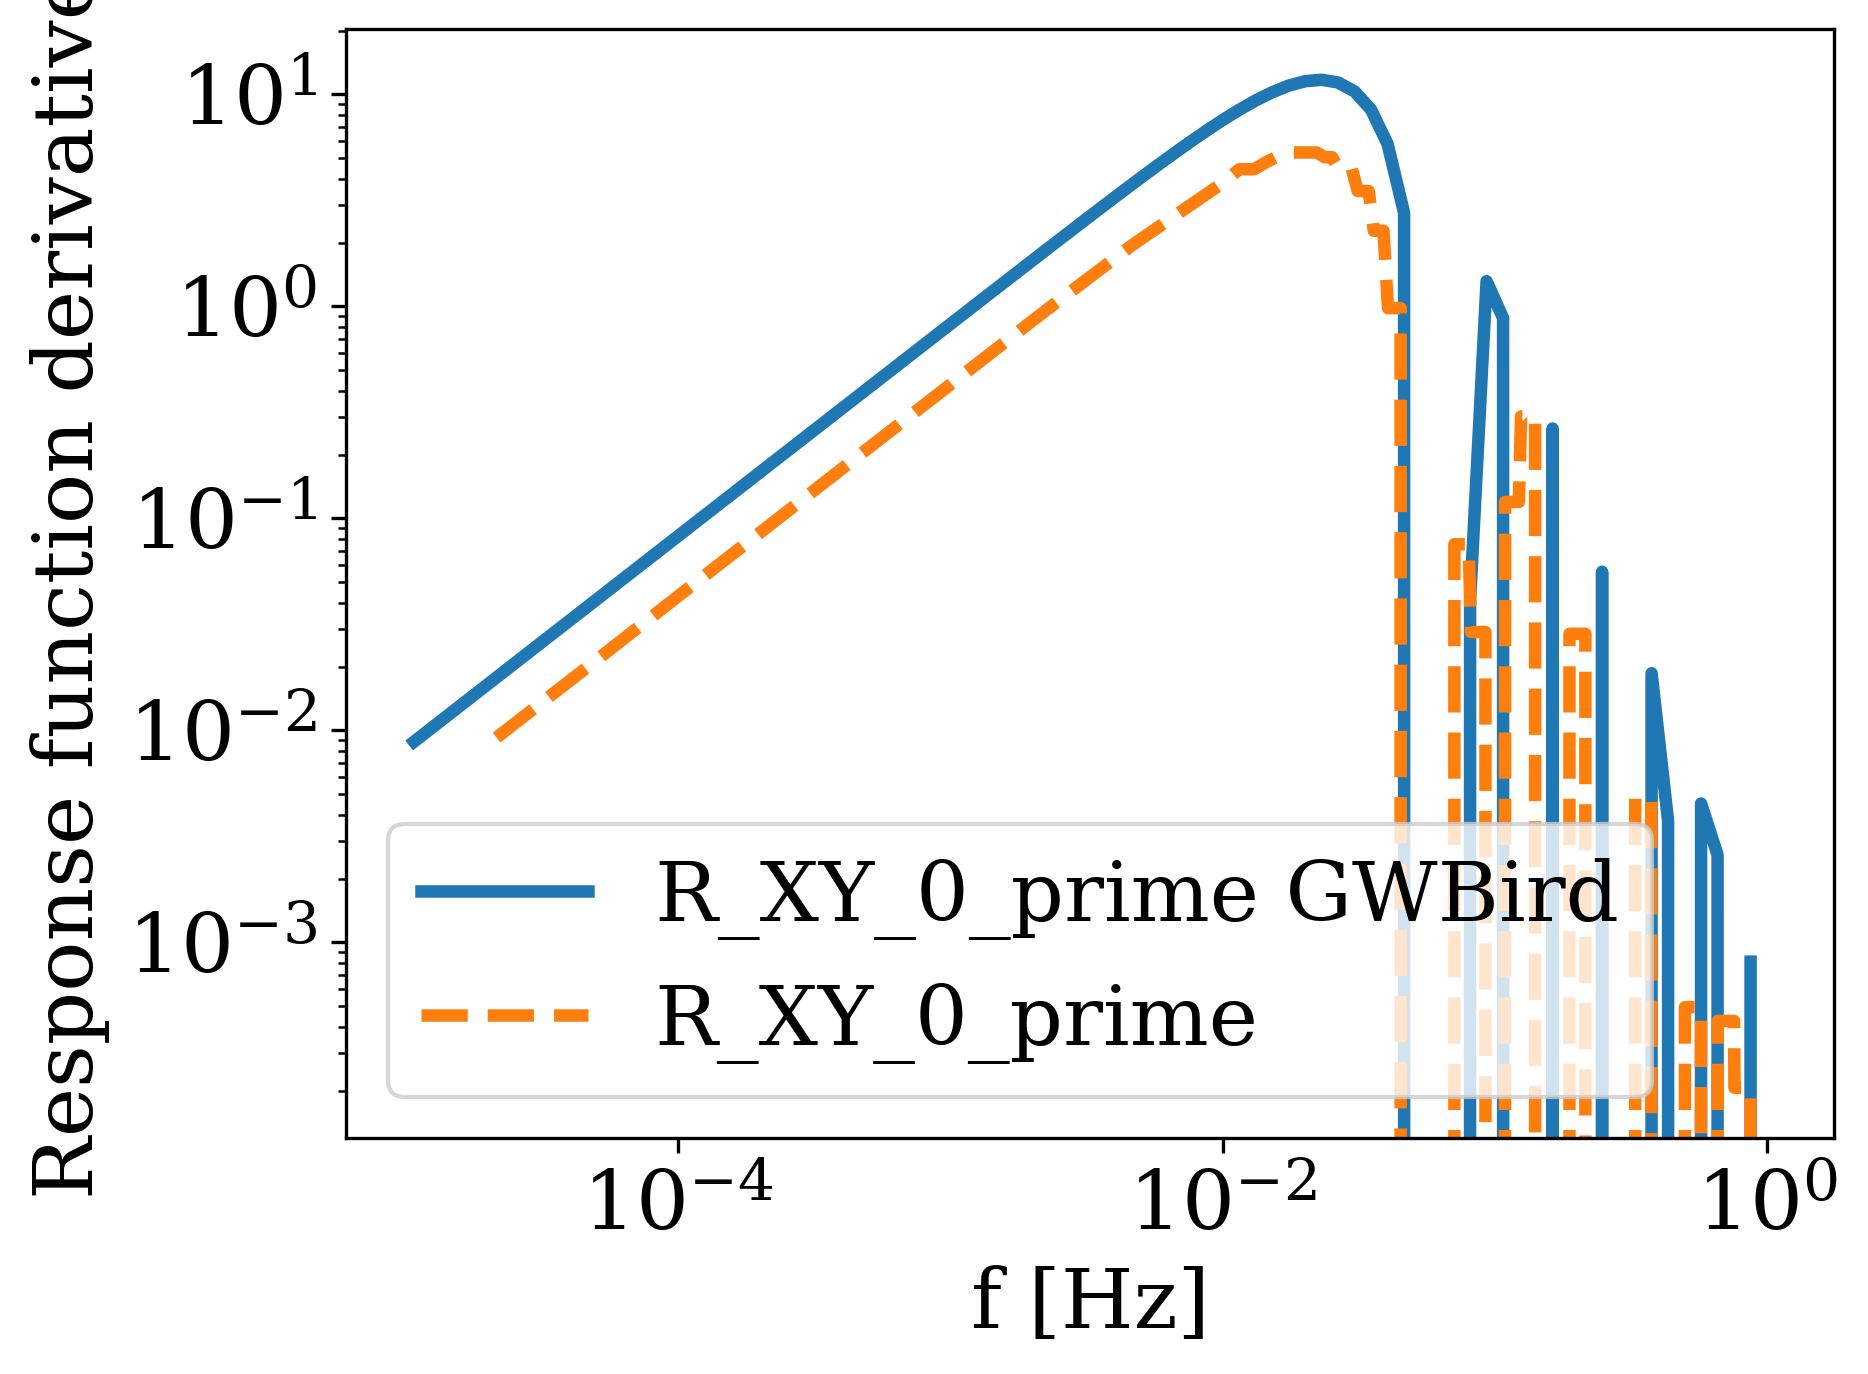

In [449]:
from scipy.interpolate import interp1d
from scipy.misc import derivative
import matplotlib.pyplot as plt

f = np.logspace(-6, 0, 100)

R_XX_0 = nell.Rlm_transfer(0, 0, u1, v1, c1, u1, v1, c1, 0, f, 't', L)
R_XY_0 = nell.Rlm_transfer(0, 0, u1, v1, c1, u2, v2, c2, 0, f, 't', L)

R1_vec_ell = Response_ell(lA,lA,xA,xA,f,f_star, 0, 0)
R2_vec_ell = Response_ell(lA,lB,xA,xB,f,f_star, 0, 0)



# Crea una funzione di interpolazione per i tuoi dati
R_XX_0_func = interp1d(f, R_XX_0)
R_XY_0_func = interp1d(f, R_XY_0)

# Calcola la derivata solo per i valori di f all'interno del range di interpolazione
f_interp = f[(f > 1e-5) & (f <= 1.0-1e-6)]

# Ora puoi calcolare la derivata di queste funzioni
R_XX_0_prime = derivative(R_XX_0_func, f_interp, dx=1e-6)
R_XY_0_prime = derivative(R_XY_0_func, f_interp, dx=1e-6)

# Crea una funzione di interpolazione per i tuoi dati
R1_vec_ell_func = interp1d(f, R1_vec_ell)
R2_vec_ell_func = interp1d(f, R2_vec_ell)

# Calcola la derivata solo per i valori di f_vec all'interno del range di interpolazione
f_vec_interp = f_vec[(f_vec > 1e-5) & (f_vec <= 1.0-1e-6)]

# Ora puoi calcolare la derivata di queste funzioni
R_XX_0_ref_prime = derivative(R1_vec_ell_func, f_vec_interp, dx=1e-6)
R_XY_0_ref_prime = derivative(R2_vec_ell_func, f_vec_interp, dx=1e-6)

# Plotta i risultati
# plt.loglog(f_interp, np.abs(R_XX_0_prime), label='R_XX_0_prime GWBird')
plt.loglog(f_interp, R_XY_0_prime, label='R_XY_0_prime GWBird')
#plt.loglog(f_vec_interp, np.abs(R_XX_0_ref_prime), label='R_XX_0_prime', linestyle='--')
plt.loglog(f_vec_interp, R_XY_0_ref_prime, label='R_XY_0_prime', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Response function derivative')
plt.legend()
plt.show()

